# Why DCGAN instead of GAN?

Generative Adversarial Networks (GANs) use two networks to generate data (generator) and classify if it is real or generated (discriminator). These two networks continuously tries to improve their abilities and after training one can supply some noise to the generator and it will generate some output, e.g. a cat if it has been trained on cat pictures.  

Problems with GANs are that they are hard to train, the model can collapse, slight changes in variables/architecture can destabilize the model, i.e. training GANs is somewhat of an art according to some. Deep Convolutional GANs (DCGANs) solves/mitigates these problems.  

### Main differences between DCGANs and GANs
Making three changes to GANs allows them to become more stable and produce better results.  

The first change is to replace pooling functions with convolution layers.  
The second change is to remove fully connected layers on top of convolutional layers.  
The third change to use batch normalization (although with some caveats...)

![title](./guidelines.png)

Source: DCGAN-paper by Radford, Metz & Chintala  
https://arxiv.org/pdf/1511.06434.pdf

## General Architecture of DCGANs
The general architecture of a DCGAN is very similar to a GAN, both can even contain deep convolutional layers despite the names. The architecture consists of a generator which generates an image out of some initial noise and a discriminator which classifies real and fake images. The picture below gives an overview of a GAN/DCGAN.

![title](./GAN-architecture.png)

Source: https://towardsdatascience.com/deep-generative-models-25ab2821afd3 

### DCGAN loss function
Our DCGAN will use two cost functions, one for the generator and one for the discriminator. One can choose among several different cost functions for the the generator, we chose a heuristically motivated cost function which ensures that the "losing" network's gradient is strong. 

- Ex~pdata = Average value that x takes when it is drawn from its distribution
- z = Input distribution to generator 
- G(z) = Output from the generator given z
- D(G(z)) = The discriminators classification of G(z), i.e. real or false

**Generator loss function**     
![title](./generatorCost.png)


**Discriminator loss function**
![title](./discriminatorCost.png)

Source: NIPS 2016 Tutorial: Generative Adversarial Networks  
https://arxiv.org/pdf/1701.00160.pdf

### Initial hyperparameters  
The DCGAN-paper presents some hyperparameters which worked well

- Mini-batch size: 128
- Weights initialization: Zero-centered normal distribution with standard deviation 0.02
- LeakyReLU leak: 0.2
- Optimizer: Adam with learning rate 0.0002 and Beta1 0.5 (default, 0.9, caused oscillations). Beta1 is momentum decay  

The DCGAN-paper's authors also mention that removing bias and scaling parameters from batch norm gave better results.


In [1]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import os
import datetime
import pytz # For time stuff

%matplotlib inline

# to make this notebook's output stable across runs (from lab2)
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
print(f"TensorFlow version: {tf.__version__}")
print(f"tf.Keras version: {tf.keras.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Pytz version: {pytz.__version__}")
print(f"Numpy version: {np.__version__}")

mnist = tf.keras.datasets.mnist
(train_imgs, train_labels), (_, _) = mnist.load_data()

C:\Users\Megatron\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version: 1.12.0
tf.Keras version: 2.1.6-tf
Matplotlib version: 2.2.2
Pytz version: 2018.4
Numpy version: 1.14.3


In [61]:
class DCGAN(object):
    
    def __init__(self):
        """
        Constructs DCCGAN with tf.Keras

        """ 
        
        # Set parameters
        self.rows = 28
        self.columns = 28
        self.channels = 1
        self.shape = (self.rows, self.columns, self.channels) # Image shape 
        self.batch_size = 128
        self.optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        
        # Build the models
        self.generator = self._buildGenerator()
        self.discriminator = self._buildDiscriminator()
        
        self.combined = tf.keras.Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        
        # Compile the models
        #self.generator.compile(optimizer=self.optimizer)
        self.discriminator.compile(
                optimizer=self.optimizer,
                loss="binary_crossentropy",
                metrics=["accuracy"])
        
        self.combined.compile(
                optimizer=self.optimizer,
                loss="binary_crossentropy")
        
        # Create directory in which we save generated images
        curDir = os.path.curdir
        imgFolder = "generatedImages"
        timestamp = str(datetime.datetime.now(tz=pytz.FixedOffset(60))) # Needed 60min offset
        timestamp = timestamp.replace(" ", "_").replace(":", ".")[:19] # Remove some unwanted things from the timestamp
        imgPath = os.path.join(curDir, imgFolder, timestamp)
        os.makedirs(imgPath)
        
        # Train the models
        progbar = tf.keras.utils.Progbar(target=math.floor(train_imgs.shape[0] / self.batch_size))
        test_noise = np.random.uniform(low=-1.0, high=1.0, size=(self.batch_size, 1, 1, 100)) 
        num_epochs = 50
        
        for epoch in range(num_epochs):
            for batch in range(math.floor(train_imgs.shape[0] / self.batch_size)):
                self.discriminator.trainable = True
                fake_labels = np.random.uniform(low=0, high=0.3, size=(self.batch_size,))
                true_labels = np.random.uniform(low=0.7, high=1.2, size=(self.batch_size,))
        
                noise = np.random.uniform(low=-1.0, high=1.0, size=(self.batch_size, 1, 1, 100)) # Half-batch
                fake_imgs = self.generator.predict_on_batch(noise)
                
                fromIdx = batch*self.batch_size
                toIdx = batch*self.batch_size+self.batch_size
                real_imgs = train_imgs[fromIdx:toIdx, :, :] # Extract a half-batch of training images
                real_imgs = np.expand_dims(real_imgs, 3) # Add channel axis
                real_imgs = (real_imgs / 127.5) - 1 # Pixel scaling. Resulting pixel value in range [-1, 1]
                
                # train_on_batch performs a single gradient update on a single batch of data
                d_real_loss = self.discriminator.train_on_batch(real_imgs, true_labels) # Train on real imgs
                d_fake_loss = self.discriminator.train_on_batch(fake_imgs, fake_labels) # Train on fake imgs
                #d_total_loss = np.add(d_real_loss, d_fake_loss) / 2 # Divide by 2 or not?
                 
                # Discriminator not trainable right now
                # Input noise -> G(noise) -> 28x28x1 fake_img
                # Fake_img goes into the discriminator with "true" label
                # The gradient will be updated based on how well the discriminator 
                #  can determine if it is a fake or real image
                self.discriminator.trainable = False
                g_loss = self.combined.train_on_batch(noise, true_labels)
                
                progbar.update(batch)
            
            print(f"Loss after epoch {epoch}:\n\tGenerator loss: {g_loss}\n\tDiscriminator loss: {d_real_loss} (real), {d_fake_loss} (fake)")
            
            # Generate a batch of images from the same noise after each epoch in order to track the progress
            test_imgs = self.generator.predict_on_batch(test_noise) # Generates batch_size number of images
            
            # Plot a grid of generated images after each epoch
            fig = plt.figure(figsize=(25,25))
            plt.subplots_adjust(left=0.3, bottom=0.5, right=0.6, top=0.8, wspace=0.05, hspace=0.05)
            for i in range(1, 26):
                fig.add_subplot(5,5,i).imshow(np.squeeze(test_imgs, 3)[i,:,:]) # Squeeze to remove channel axis
                plt.axis("off")
            
            # Save some generated images each epoch in order to see improvement as training progresses
            savePath = os.path.join(imgPath, f"epoch{epoch}.png")
            plt.savefig(savePath, bbox_inches="tight")
            
            # Save models after each tenth epoch    
            #if (epoch % 10 == 0):
            #    self.generator.save(f"./checkpoints/generator-{timestamp}.h5")
            #    self.discriminator.save(f"./checkpoints/combined-{timestamp}.h5")
            #    self.combined.save(f"./checkpoints/discriminator-{timestamp}.h5")
        
        # Save FINAL models when all epochs are done 
        # CHECKPOINT PATHS ARE NOT OS-INDEPENDENT
        #self.generator.save(f"./checkpoints/FINAL-generator-{timestamp}.h5")
        #self.discriminator.save(f"./checkpoints/FINAL-combined-{timestamp}.h5")
        #self.combined.save(f"./checkpoints/FINAL-discriminator-{timestamp}.h5")
        
        #imgs2 = self.generator.predict_on_batch(test_noise)
        #print(imgs2[0])
        
    def _buildGenerator(self):
        """
        Constructs the generator part of the DCGAN
        """
        ##########
        # Layers #
        ##########
      
        # In the blog post they use a reshape, is that neccessary? Investigate
        model = tf.keras.Sequential()
        
        # Read the link below to understand output shapes of Conv2DTranspose
        # https://stackoverflow.com/questions/50683039/conv2d-transpose-output-shape-using-formula
        # Output shape: (batch, new_rows, new_cols, filters)
        model.add(layers.Conv2DTranspose(input_shape=(1, 1, 100), filters=128, kernel_size=(7,7), 
                                         strides=(1,1), padding="valid",
                                         kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
        model.add(layers.BatchNormalization(scale=False, center=False))
        model.add(layers.ReLU())

        model.add(layers.Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2), padding="valid",
                                         kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
        model.add(layers.BatchNormalization(scale=False, center=False))
        model.add(layers.ReLU())

        model.add(layers.Conv2DTranspose(filters=1, kernel_size=(2,2), strides=(2,2), padding="valid",
                                         kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                                         activation='tanh'))
    
        model.summary()
        
        return model
    
    def _buildDiscriminator(self):
        """
        Constructs the discriminator part of the DCGAN
        """
        ##########
        # Layers #
        ##########
        
        model = tf.keras.Sequential()
        
        # Input is batchx28x28x1
        model.add(layers.Conv2D(input_shape=(28, 28, 1), filters=64,
                                kernel_size=(2,2), strides=(2,2), padding="valid",
                                kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
        model.add(layers.LeakyReLU(alpha=0.2))

        # Input is batchx14x14x???
        model.add(layers.Conv2D(filters=128, kernel_size=(2,2), 
                                strides=(2,2), padding="valid",
                                kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
        model.add(layers.BatchNormalization(scale=False, center=False))
        model.add(layers.LeakyReLU(alpha=0.2))

        model.add(layers.Conv2D(filters=256, kernel_size=(6,6), 
                                strides=(2,2), padding="valid",
                                kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
        model.add(layers.BatchNormalization(scale=False, center=False))
        model.add(layers.LeakyReLU(alpha=0.2))

        # Input is batchx7x7x???
        model.add(layers.Flatten()) # Output is batchx7*7*128
        model.add(layers.Dropout(rate=0.5)) 
        model.add(layers.Dense(units=1, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                               activation=tf.nn.sigmoid))

        model.summary()
        
        return model


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_33 (Conv2DT (None, 7, 7, 128)         627328    
_________________________________________________________________
batch_normalization_44 (Batc (None, 7, 7, 128)         256       
_________________________________________________________________
re_lu_22 (ReLU)              (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_34 (Conv2DT (None, 14, 14, 64)        32832     
_________________________________________________________________
batch_normalization_45 (Batc (None, 14, 14, 64)        128       
_________________________________________________________________
re_lu_23 (ReLU)              (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_35 (Conv2DT (None, 28, 28, 1)         257       
Total para

 62/468 [==>...........................] - ETA: 53sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


101/468 [=====>........................] - ETA: 37sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


140/468 [=======>......................] - ETA: 29sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


179/468 [==========>...................] - ETA: 23sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


218/468 [============>.................] - ETA: 19sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


257/468 [===============>..............] - ETA: 15sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


295/468 [=================>............] - ETA: 12sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


334/468 [====================>.........] - ETA: 9sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


373/468 [======================>.......] - ETA: 6sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


412/468 [=========================>....] - ETA: 3sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


451/468 [===========================>..] - ETA: 1sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 0sLoss after epoch 0:
	Generator loss: 0.3236912190914154
	Discriminator loss: [0.309709, 0.0] (real), [1.2929573, 0.0] (fake)
 21/468 [>.............................] - ETA: 11:23WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 60/468 [==>...........................] - ETA: 3:52WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 99/468 [=====>........................] - ETA: 2:15WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


138/468 [=======>......................] - ETA: 1:32WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


177/468 [==========>...................] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


216/468 [============>.................] - ETA: 49sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


255/468 [===============>..............] - ETA: 37sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


294/468 [=================>............] - ETA: 27sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


333/468 [====================>.........] - ETA: 19sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


372/468 [======================>.......] - ETA: 13sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


411/468 [=========================>....] - ETA: 7sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


450/468 [===========================>..] - ETA: 2sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 0sLoss after epoch 1:
	Generator loss: 0.2969157099723816
	Discriminator loss: [0.28136712, 0.0] (real), [1.4065266, 0.0] (fake)
 20/468 [>.............................] - ETA: 21:44WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 59/468 [==>...........................] - ETA: 6:58WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 98/468 [=====>........................] - ETA: 3:56WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


137/468 [=======>......................] - ETA: 2:36WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


179/468 [==========>...................] - ETA: 1:47WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


222/468 [=============>................] - ETA: 1:16WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


264/468 [===============>..............] - ETA: 55sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


306/468 [==================>...........] - ETA: 38sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


348/468 [=====================>........] - ETA: 26sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


390/468 [========================>.....] - ETA: 15sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


432/468 [==========================>...] - ETA: 6sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 0sLoss after epoch 2:
	Generator loss: 0.3009285032749176
	Discriminator loss: [0.28221914, 0.0] (real), [1.389345, 0.0] (fake)
  6/468 [..............................] - ETA: 1:46:40WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 48/468 [==>...........................] - ETA: 12:26WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 92/468 [====>.........................] - ETA: 5:58WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


134/468 [=======>......................] - ETA: 3:43WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


176/468 [==========>...................] - ETA: 2:32WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


218/468 [============>.................] - ETA: 1:48WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


261/468 [===============>..............] - ETA: 1:16WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


303/468 [==================>...........] - ETA: 53sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


346/468 [=====================>........] - ETA: 35sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


389/468 [=======================>......] - ETA: 20sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


430/468 [==========================>...] - ETA: 9sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 0sLoss after epoch 3:
	Generator loss: 0.30905330181121826
	Discriminator loss: [0.2925831, 0.0] (real), [1.412433, 0.0] (fake)
  4/468 [..............................] - ETA: 3:29:11WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 47/468 [==>...........................] - ETA: 16:29WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 90/468 [====>.........................] - ETA: 7:53WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


133/468 [=======>......................] - ETA: 4:49WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


174/468 [==========>...................] - ETA: 3:17WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


217/468 [============>.................] - ETA: 2:18WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


257/468 [===============>..............] - ETA: 1:39WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


299/468 [==================>...........] - ETA: 1:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


340/468 [====================>.........] - ETA: 47sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


382/468 [=======================>......] - ETA: 28sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


424/468 [==========================>...] - ETA: 13sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 0sLoss after epoch 4:
	Generator loss: 0.30461880564689636
	Discriminator loss: [0.2653889, 0.0] (real), [1.3533586, 0.0] (fake)


 40/468 [=>............................] - ETA: 24:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 82/468 [====>.........................] - ETA: 10:47WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


124/468 [======>.......................] - ETA: 6:27WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


166/468 [=========>....................] - ETA: 4:18WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


209/468 [============>.................] - ETA: 2:58WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


251/468 [===============>..............] - ETA: 2:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


294/468 [=================>............] - ETA: 1:28WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


338/468 [====================>.........] - ETA: 58sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


380/468 [=======================>......] - ETA: 35sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


424/468 [==========================>...] - ETA: 16sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 0sLoss after epoch 5:
	Generator loss: 0.30218517780303955
	Discriminator loss: [0.26316592, 0.0] (real), [1.3429425, 0.0] (fake)


 41/468 [=>............................] - ETA: 28:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 83/468 [====>.........................] - ETA: 12:42WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


125/468 [=======>......................] - ETA: 7:37WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


167/468 [=========>....................] - ETA: 5:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


210/468 [============>.................] - ETA: 3:30WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


254/468 [===============>..............] - ETA: 2:26WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


294/468 [=================>............] - ETA: 1:43WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


333/468 [====================>.........] - ETA: 1:12WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


372/468 [======================>.......] - ETA: 46sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


411/468 [=========================>....] - ETA: 25sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


450/468 [===========================>..] - ETA: 7sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 0sLoss after epoch 6:
	Generator loss: 0.3278339207172394
	Discriminator loss: [0.29592776, 0.0] (real), [1.3316233, 0.0] (fake)
 20/468 [>.............................] - ETA: 1:09:47WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 59/468 [==>...........................] - ETA: 21:50WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 98/468 [=====>........................] - ETA: 12:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


137/468 [=======>......................] - ETA: 7:47WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


176/468 [==========>...................] - ETA: 5:24WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


215/468 [============>.................] - ETA: 3:52WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


254/468 [===============>..............] - ETA: 2:48WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


293/468 [=================>............] - ETA: 2:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


332/468 [====================>.........] - ETA: 1:23WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


371/468 [======================>.......] - ETA: 53sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


410/468 [=========================>....] - ETA: 29sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


449/468 [===========================>..] - ETA: 8sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 0sLoss after epoch 7:
	Generator loss: 0.3301505446434021
	Discriminator loss: [0.27610326, 0.0] (real), [1.2883198, 0.0] (fake)
 19/468 [>.............................] - ETA: 1:23:59WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 61/468 [==>...........................] - ETA: 23:57WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


103/468 [=====>........................] - ETA: 12:51WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


144/468 [========>.....................] - ETA: 8:14WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


186/468 [==========>...................] - ETA: 5:36WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


229/468 [=============>................] - ETA: 3:54WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


270/468 [================>.............] - ETA: 2:46WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


313/468 [===================>..........] - ETA: 1:53WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


355/468 [=====================>........] - ETA: 1:13WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


398/468 [========================>.....] - ETA: 41sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


441/468 [===========================>..] - ETA: 14sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 0sLoss after epoch 8:
	Generator loss: 0.33915621042251587
	Discriminator loss: [0.29724398, 0.0] (real), [1.2748117, 0.0] (fake)
 15/468 [..............................] - ETA: 1:59:57WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 57/468 [==>...........................] - ETA: 28:54WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 97/468 [=====>........................] - ETA: 15:27WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


139/468 [=======>......................] - ETA: 9:39WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


182/468 [==========>...................] - ETA: 6:28WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


225/468 [=============>................] - ETA: 4:29WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


268/468 [================>.............] - ETA: 3:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


310/468 [==================>...........] - ETA: 2:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


354/468 [=====================>........] - ETA: 1:22WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


396/468 [========================>.....] - ETA: 46sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


439/468 [===========================>..] - ETA: 17sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 0sLoss after epoch 9:
	Generator loss: 0.33400124311447144
	Discriminator loss: [0.28381285, 0.0] (real), [1.2966326, 0.0] (fake)
 13/468 [..............................] - ETA: 2:33:40WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 56/468 [==>...........................] - ETA: 32:34WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 97/468 [=====>........................] - ETA: 17:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


139/468 [=======>......................] - ETA: 10:39WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


183/468 [==========>...................] - ETA: 7:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


225/468 [=============>................] - ETA: 4:56WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


269/468 [================>.............] - ETA: 3:24WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


312/468 [===================>..........] - ETA: 2:19WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


353/468 [=====================>........] - ETA: 1:31WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


394/468 [========================>.....] - ETA: 53sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


436/468 [==========================>...] - ETA: 20sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 0sLoss after epoch 10:
	Generator loss: 0.33970215916633606
	Discriminator loss: [0.2782589, 0.0] (real), [1.3091737, 0.0] (fake)
 11/468 [..............................] - ETA: 3:19:49WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 52/468 [==>...........................] - ETA: 38:45WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 95/468 [=====>........................] - ETA: 19:10WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


136/468 [=======>......................] - ETA: 12:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


178/468 [==========>...................] - ETA: 8:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


220/468 [=============>................] - ETA: 5:37WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


262/468 [===============>..............] - ETA: 3:57WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


305/468 [==================>...........] - ETA: 2:42WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


348/468 [=====================>........] - ETA: 1:45WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


391/468 [========================>.....] - ETA: 1:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


434/468 [==========================>...] - ETA: 24sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 0sLoss after epoch 11:
	Generator loss: 0.3472922742366791
	Discriminator loss: [0.26846218, 0.0] (real), [1.2549703, 0.0] (fake)
  7/468 [..............................] - ETA: 5:44:12WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 49/468 [==>...........................] - ETA: 45:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 91/468 [====>.........................] - ETA: 21:57WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


134/468 [=======>......................] - ETA: 13:18WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


176/468 [==========>...................] - ETA: 8:55WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


219/468 [=============>................] - ETA: 6:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


262/468 [===============>..............] - ETA: 4:17WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


304/468 [==================>...........] - ETA: 2:57WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


347/468 [=====================>........] - ETA: 1:55WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


390/468 [========================>.....] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


432/468 [==========================>...] - ETA: 27sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 0sLoss after epoch 12:
	Generator loss: 0.3822541832923889
	Discriminator loss: [0.33584192, 0.0] (real), [1.2202535, 0.0] (fake)
  5/468 [..............................] - ETA: 8:42:50 WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 46/468 [=>............................] - ETA: 52:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 88/468 [====>.........................] - ETA: 24:41WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


130/468 [=======>......................] - ETA: 14:58WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


170/468 [=========>....................] - ETA: 10:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


213/468 [============>.................] - ETA: 6:58WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


253/468 [===============>..............] - ETA: 4:59WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


296/468 [=================>............] - ETA: 3:25WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


339/468 [====================>.........] - ETA: 2:15WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


380/468 [=======================>......] - ETA: 1:23WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


423/468 [==========================>...] - ETA: 38sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


466/468 [============================>.] - ETA: 1sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Loss after epoch 13:
	Generator loss: 0.3617231845855713
	Discriminator loss: [0.3212163, 0.0] (real), [1.2266061, 0.0] (fake)
 38/468 [=>............................] - ETA: 1:09:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 79/468 [====>.........................] - ETA: 30:12WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


121/468 [======>.......................] - ETA: 17:41WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


163/468 [=========>....................] - ETA: 11:37WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


206/468 [============>.................] - ETA: 7:56WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


250/468 [===============>..............] - ETA: 5:28WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


292/468 [=================>............] - ETA: 3:48WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


335/468 [====================>.........] - ETA: 2:31WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


377/468 [=======================>......] - ETA: 1:32WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


419/468 [=========================>....] - ETA: 45sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


460/468 [============================>.] - ETA: 6sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 0sLoss after epoch 14:
	Generator loss: 0.34696903824806213
	Discriminator loss: [0.30467266, 0.0] (real), [1.241684, 0.0] (fake)
 32/468 [=>............................] - ETA: 1:28:46WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 74/468 [===>..........................] - ETA: 34:53WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


116/468 [======>.......................] - ETA: 19:59WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


157/468 [=========>....................] - ETA: 13:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


198/468 [===========>..................] - ETA: 9:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


241/468 [==============>...............] - ETA: 6:18WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


283/468 [=================>............] - ETA: 4:24WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


324/468 [===================>..........] - ETA: 3:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


366/468 [======================>.......] - ETA: 1:53WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


408/468 [=========================>....] - ETA: 1:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


449/468 [===========================>..] - ETA: 17sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 0sLoss after epoch 15:
	Generator loss: 0.3688593804836273
	Discriminator loss: [0.30222654, 0.0] (real), [1.2280452, 0.0] (fake)
 21/468 [>.............................] - ETA: 2:27:39WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 63/468 [===>..........................] - ETA: 44:50WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


104/468 [=====>........................] - ETA: 24:32WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


145/468 [========>.....................] - ETA: 15:41WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


186/468 [==========>...................] - ETA: 10:44WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


227/468 [=============>................] - ETA: 7:33WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


269/468 [================>.............] - ETA: 5:17WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


309/468 [==================>...........] - ETA: 3:42WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


351/468 [=====================>........] - ETA: 2:24WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


393/468 [========================>.....] - ETA: 1:23WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


435/468 [==========================>...] - ETA: 33sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 0sLoss after epoch 16:
	Generator loss: 0.36793333292007446
	Discriminator loss: [0.29853842, 0.0] (real), [1.2093074, 0.0] (fake)
  8/468 [..............................] - ETA: 7:02:56WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 49/468 [==>...........................] - ETA: 1:03:12WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 90/468 [====>.........................] - ETA: 31:12WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


132/468 [=======>......................] - ETA: 19:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


173/468 [==========>...................] - ETA: 12:47WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


215/468 [============>.................] - ETA: 8:52WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


256/468 [===============>..............] - ETA: 6:16WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


299/468 [==================>...........] - ETA: 4:18WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


340/468 [====================>.........] - ETA: 2:52WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


382/468 [=======================>......] - ETA: 1:43WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


425/468 [==========================>...] - ETA: 46sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 0sLoss after epoch 17:
	Generator loss: 0.375791072845459
	Discriminator loss: [0.3318359, 0.0] (real), [1.2162948, 0.0] (fake)


 39/468 [=>............................] - ETA: 1:25:55WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 80/468 [====>.........................] - ETA: 38:03WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


120/468 [======>.......................] - ETA: 22:51WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


162/468 [=========>....................] - ETA: 14:57WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


204/468 [============>.................] - ETA: 10:17WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


247/468 [==============>...............] - ETA: 7:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


288/468 [=================>............] - ETA: 5:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


329/468 [====================>.........] - ETA: 3:24WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


370/468 [======================>.......] - ETA: 2:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


412/468 [=========================>....] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


454/468 [============================>.] - ETA: 15sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 1sLoss after epoch 18:
	Generator loss: 0.3539603054523468
	Discriminator loss: [0.3005851, 0.0] (real), [1.255161, 0.0] (fake)
 27/468 [>.............................] - ETA: 2:14:19WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 70/468 [===>..........................] - ETA: 46:58WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


112/468 [======>.......................] - ETA: 26:22WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


155/468 [========>.....................] - ETA: 16:49WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


197/468 [===========>..................] - ETA: 11:31WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


240/468 [==============>...............] - ETA: 7:59WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


283/468 [=================>............] - ETA: 5:31WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


324/468 [===================>..........] - ETA: 3:46WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


365/468 [======================>.......] - ETA: 2:24WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


408/468 [=========================>....] - ETA: 1:15WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


450/468 [===========================>..] - ETA: 20sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


466/468 [============================>.] - ETA: 2sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
Loss after epoch 19:
	Generator loss: 0.3794236183166504
	Discriminator loss: [0.3349054, 0.0] (real), [1.1897458, 0.0] (fake)
 25/468 [>.............................] - ETA: 2:33:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 65/468 [===>..........................] - ETA: 53:48WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


105/468 [=====>........................] - ETA: 30:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


145/468 [========>.....................] - ETA: 19:29WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


187/468 [==========>...................] - ETA: 13:12WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


229/468 [=============>................] - ETA: 9:12WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


270/468 [================>.............] - ETA: 6:29WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


312/468 [===================>..........] - ETA: 4:26WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


354/468 [=====================>........] - ETA: 2:52WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


396/468 [========================>.....] - ETA: 1:37WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


439/468 [===========================>..] - ETA: 35sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 1sLoss after epoch 20:
	Generator loss: 0.37271755933761597
	Discriminator loss: [0.30586314, 0.0] (real), [1.2164731, 0.0] (fake)


C:\Users\Megatron\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


 40/468 [=>............................] - ETA: 1:37:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 81/468 [====>.........................] - ETA: 43:33WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


123/468 [======>.......................] - ETA: 25:40WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


165/468 [=========>....................] - ETA: 16:52WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


207/468 [============>.................] - ETA: 11:38WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


250/468 [===============>..............] - ETA: 8:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


292/468 [=================>............] - ETA: 5:36WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


333/468 [====================>.........] - ETA: 3:47WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


375/468 [=======================>......] - ETA: 2:19WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


415/468 [=========================>....] - ETA: 1:12WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


457/468 [============================>.] - ETA: 13sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


466/468 [============================>.] - ETA: 2sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
Loss after epoch 21:
	Generator loss: 0.366340696811676
	Discriminator loss: [0.32150042, 0.0] (real), [1.2163861, 0.0] (fake)
 32/468 [=>............................] - ETA: 2:09:23WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 73/468 [===>..........................] - ETA: 51:35WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


112/468 [======>.......................] - ETA: 30:24WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


151/468 [========>.....................] - ETA: 20:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


191/468 [===========>..................] - ETA: 13:58WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


232/468 [=============>................] - ETA: 9:50WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


274/468 [================>.............] - ETA: 6:52WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


315/468 [===================>..........] - ETA: 4:44WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


357/468 [=====================>........] - ETA: 3:02WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


399/468 [========================>.....] - ETA: 1:41WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


442/468 [===========================>..] - ETA: 34sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


466/468 [============================>.] - ETA: 2sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
Loss after epoch 22:
	Generator loss: 0.34343984723091125
	Discriminator loss: [0.32871342, 0.0] (real), [1.209878, 0.0] (fake)
 14/468 [..............................] - ETA: 5:21:19WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 54/468 [==>...........................] - ETA: 1:16:14WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 97/468 [=====>........................] - ETA: 38:10WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


139/468 [=======>......................] - ETA: 23:42WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


182/468 [==========>...................] - ETA: 15:48WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


223/468 [=============>................] - ETA: 11:05WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


267/468 [================>.............] - ETA: 7:37WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


310/468 [==================>...........] - ETA: 5:10WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


353/468 [=====================>........] - ETA: 3:19WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


394/468 [========================>.....] - ETA: 1:55WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


435/468 [==========================>...] - ETA: 46sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 1sLoss after epoch 23:
	Generator loss: 0.3758052587509155
	Discriminator loss: [0.32694173, 0.0] (real), [1.236349, 0.0] (fake)
  8/468 [..............................] - ETA: 9:53:37 WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 49/468 [==>...........................] - ETA: 1:28:35WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 91/468 [====>.........................] - ETA: 43:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


132/468 [=======>......................] - ETA: 26:33WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


176/468 [==========>...................] - ETA: 17:22WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


218/468 [============>.................] - ETA: 12:03WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


260/468 [===============>..............] - ETA: 8:26WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


303/468 [==================>...........] - ETA: 5:45WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


346/468 [=====================>........] - ETA: 3:44WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


390/468 [========================>.....] - ETA: 2:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


431/468 [==========================>...] - ETA: 55sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 1sLoss after epoch 24:
	Generator loss: 0.37850087881088257
	Discriminator loss: [0.34676546, 0.0] (real), [1.2326622, 0.0] (fake)
  2/468 [..............................] - ETA: 41:42:28WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 43/468 [=>............................] - ETA: 1:46:30WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 84/468 [====>.........................] - ETA: 49:25WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


125/468 [=======>......................] - ETA: 29:46WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


165/468 [=========>....................] - ETA: 19:59WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


208/468 [============>.................] - ETA: 13:39WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


250/468 [===============>..............] - ETA: 9:33WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


292/468 [=================>............] - ETA: 6:37WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


332/468 [====================>.........] - ETA: 4:31WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


374/468 [======================>.......] - ETA: 2:46WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


415/468 [=========================>....] - ETA: 1:25WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


458/468 [============================>.] - ETA: 14sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 1sLoss after epoch 25:
	Generator loss: 0.36546945571899414
	Discriminator loss: [0.31717974, 0.0] (real), [1.2061583, 0.0] (fake)
 31/468 [>.............................] - ETA: 2:37:43WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 73/468 [===>..........................] - ETA: 1:00:44WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


115/468 [======>.......................] - ETA: 34:34WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


158/468 [=========>....................] - ETA: 22:10WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


199/468 [===========>..................] - ETA: 15:19WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


243/468 [==============>...............] - ETA: 10:31WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


285/468 [=================>............] - ETA: 7:19WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


327/468 [===================>..........] - ETA: 4:56WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


369/468 [======================>.......] - ETA: 3:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


411/468 [=========================>....] - ETA: 1:35WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


454/468 [============================>.] - ETA: 21sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 1sLoss after epoch 26:
	Generator loss: 0.36939913034439087
	Discriminator loss: [0.35991228, 0.0] (real), [1.2857189, 0.0] (fake)
 27/468 [>.............................] - ETA: 3:09:34WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 67/468 [===>..........................] - ETA: 1:09:40WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


109/468 [=====>........................] - ETA: 38:27WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


152/468 [========>.....................] - ETA: 24:21WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


193/468 [===========>..................] - ETA: 16:44WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


235/468 [==============>...............] - ETA: 11:41WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


277/468 [================>.............] - ETA: 8:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


318/468 [===================>..........] - ETA: 5:35WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


360/468 [======================>.......] - ETA: 3:34WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


401/468 [========================>.....] - ETA: 1:59WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


442/468 [===========================>..] - ETA: 42sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


466/468 [============================>.] - ETA: 3sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
Loss after epoch 27:
	Generator loss: 0.35472023487091064
	Discriminator loss: [0.29543695, 0.0] (real), [1.2274323, 0.0] (fake)
 15/468 [..............................] - ETA: 6:03:14WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 56/468 [==>...........................] - ETA: 1:28:45WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 96/468 [=====>........................] - ETA: 46:53WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


136/468 [=======>......................] - ETA: 29:37WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


178/468 [==========>...................] - ETA: 19:49WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


220/468 [=============>................] - ETA: 13:45WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


262/468 [===============>..............] - ETA: 9:37WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


303/468 [==================>...........] - ETA: 6:41WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


347/468 [=====================>........] - ETA: 4:17WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


389/468 [=======================>......] - ETA: 2:30WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


431/468 [==========================>...] - ETA: 1:03WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 1sLoss after epoch 28:
	Generator loss: 0.3718384802341461
	Discriminator loss: [0.31844544, 0.0] (real), [1.1999106, 0.0] (fake)
  6/468 [..............................] - ETA: 15:58:10WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 48/468 [==>...........................] - ETA: 1:49:12WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 89/468 [====>.........................] - ETA: 53:17WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


131/468 [=======>......................] - ETA: 32:17WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


174/468 [==========>...................] - ETA: 21:16WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


217/468 [============>.................] - ETA: 14:36WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


258/468 [===============>..............] - ETA: 10:18WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


299/468 [==================>...........] - ETA: 7:10WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


338/468 [====================>.........] - ETA: 4:53WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


377/468 [=======================>......] - ETA: 3:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


420/468 [=========================>....] - ETA: 1:27WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


461/468 [============================>.] - ETA: 11sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 1sLoss after epoch 29:
	Generator loss: 0.3640909790992737
	Discriminator loss: [0.32406747, 0.0] (real), [1.2674383, 0.0] (fake)
 33/468 [=>............................] - ETA: 2:49:56WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 74/468 [===>..........................] - ETA: 1:08:50WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


115/468 [======>.......................] - ETA: 39:47WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


155/468 [========>.....................] - ETA: 26:15WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


196/468 [===========>..................] - ETA: 18:05WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


238/468 [==============>...............] - ETA: 12:38WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


279/468 [================>.............] - ETA: 8:52WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


319/468 [===================>..........] - ETA: 6:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


361/468 [======================>.......] - ETA: 3:54WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


401/468 [========================>.....] - ETA: 2:12WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


441/468 [===========================>..] - ETA: 48sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


466/468 [============================>.] - ETA: 3sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
Loss after epoch 30:
	Generator loss: 0.36366039514541626
	Discriminator loss: [0.31793475, 0.0] (real), [1.232264, 0.0] (fake)
 14/468 [..............................] - ETA: 7:11:23WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 55/468 [==>...........................] - ETA: 1:40:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 98/468 [=====>........................] - ETA: 50:30WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


138/468 [=======>......................] - ETA: 32:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


180/468 [==========>...................] - ETA: 21:31WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


220/468 [=============>................] - ETA: 15:12WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


259/468 [===============>..............] - ETA: 10:54WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


300/468 [==================>...........] - ETA: 7:35WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


340/468 [====================>.........] - ETA: 5:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


383/468 [=======================>......] - ETA: 3:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


423/468 [==========================>...] - ETA: 1:27WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


465/468 [============================>.] - ETA: 5sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 1sLoss after epoch 31:
	Generator loss: 0.33797603845596313
	Discriminator loss: [0.2940582, 0.0] (real), [1.2730119, 0.0] (fake)
 37/468 [=>............................] - ETA: 2:40:11WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 79/468 [====>.........................] - ETA: 1:07:53WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


119/468 [======>.......................] - ETA: 40:32WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


159/468 [=========>....................] - ETA: 26:56WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


201/468 [===========>..................] - ETA: 18:27WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


241/468 [==============>...............] - ETA: 13:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


281/468 [=================>............] - ETA: 9:17WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


324/468 [===================>..........] - ETA: 6:13WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


365/468 [======================>.......] - ETA: 3:57WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


406/468 [=========================>....] - ETA: 2:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


447/468 [===========================>..] - ETA: 39sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 1sLoss after epoch 32:
	Generator loss: 0.351207435131073
	Discriminator loss: [0.3066854, 0.0] (real), [1.21768, 0.0] (fake)
 21/468 [>.............................] - ETA: 5:01:29WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 62/468 [==>...........................] - ETA: 1:32:59WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


102/468 [=====>........................] - ETA: 51:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


142/468 [========>.....................] - ETA: 32:45WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


182/468 [==========>...................] - ETA: 22:29WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


221/468 [=============>................] - ETA: 16:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


260/468 [===============>..............] - ETA: 11:30WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


299/468 [==================>...........] - ETA: 8:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


338/468 [====================>.........] - ETA: 5:33WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


377/468 [=======================>......] - ETA: 3:29WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


416/468 [=========================>....] - ETA: 1:48WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


455/468 [============================>.] - ETA: 24sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 1sLoss after epoch 33:
	Generator loss: 0.3364650011062622
	Discriminator loss: [0.30842733, 0.0] (real), [1.274297, 0.0] (fake)
 25/468 [>.............................] - ETA: 4:18:48WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 63/468 [===>..........................] - ETA: 1:34:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


101/468 [=====>........................] - ETA: 53:19WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


140/468 [=======>......................] - ETA: 34:27WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


179/468 [==========>...................] - ETA: 23:48WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


218/468 [============>.................] - ETA: 16:56WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


257/468 [===============>..............] - ETA: 12:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


296/468 [=================>............] - ETA: 8:37WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


335/468 [====================>.........] - ETA: 5:54WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


374/468 [======================>.......] - ETA: 3:45WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


413/468 [=========================>....] - ETA: 1:59WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


452/468 [===========================>..] - ETA: 31sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 1sLoss after epoch 34:
	Generator loss: 0.36352837085723877
	Discriminator loss: [0.3096413, 0.0] (real), [1.2217076, 0.0] (fake)
 22/468 [>.............................] - ETA: 5:04:48WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 60/468 [==>...........................] - ETA: 1:42:28WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 98/468 [=====>........................] - ETA: 57:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


137/468 [=======>......................] - ETA: 36:34WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


176/468 [==========>...................] - ETA: 25:10WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


215/468 [============>.................] - ETA: 17:53WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


254/468 [===============>..............] - ETA: 12:50WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


293/468 [=================>............] - ETA: 9:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


332/468 [====================>.........] - ETA: 6:16WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


371/468 [======================>.......] - ETA: 4:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


410/468 [=========================>....] - ETA: 2:10WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


449/468 [===========================>..] - ETA: 39sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 1sLoss after epoch 35:
	Generator loss: 0.37513720989227295
	Discriminator loss: [0.327137, 0.0] (real), [1.2583584, 0.0] (fake)
 19/468 [>.............................] - ETA: 6:05:18WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 57/468 [==>...........................] - ETA: 1:51:42WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 95/468 [=====>........................] - ETA: 1:00:57WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


134/468 [=======>......................] - ETA: 38:47WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


173/468 [==========>...................] - ETA: 26:35WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


212/468 [============>.................] - ETA: 18:52WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


251/468 [===============>..............] - ETA: 13:32WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


290/468 [=================>............] - ETA: 9:38WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


329/468 [====================>.........] - ETA: 6:38WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


368/468 [======================>.......] - ETA: 4:17WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


407/468 [=========================>....] - ETA: 2:22WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


446/468 [===========================>..] - ETA: 46sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 2sLoss after epoch 36:
	Generator loss: 0.359832227230072
	Discriminator loss: [0.33111238, 0.0] (real), [1.2455871, 0.0] (fake)
 16/468 [>.............................] - ETA: 7:28:41WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 54/468 [==>...........................] - ETA: 2:02:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 92/468 [====>.........................] - ETA: 1:05:11WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


131/468 [=======>......................] - ETA: 41:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


170/468 [=========>....................] - ETA: 28:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


209/468 [============>.................] - ETA: 19:53WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


248/468 [==============>...............] - ETA: 14:16WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


287/468 [=================>............] - ETA: 10:10WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


326/468 [===================>..........] - ETA: 7:02WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


365/468 [======================>.......] - ETA: 4:34WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


404/468 [========================>.....] - ETA: 2:34WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


443/468 [===========================>..] - ETA: 55sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 2sLoss after epoch 37:
	Generator loss: 0.3660413324832916
	Discriminator loss: [0.33631608, 0.0] (real), [1.214282, 0.0] (fake)
 13/468 [..............................] - ETA: 9:30:45 WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 51/468 [==>...........................] - ETA: 2:13:38WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 91/468 [====>.........................] - ETA: 1:07:51WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


131/468 [=======>......................] - ETA: 42:14WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


170/468 [=========>....................] - ETA: 28:50WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


209/468 [============>.................] - ETA: 20:26WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


248/468 [==============>...............] - ETA: 14:39WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


287/468 [=================>............] - ETA: 10:26WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


326/468 [===================>..........] - ETA: 7:13WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


365/468 [======================>.......] - ETA: 4:41WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


404/468 [========================>.....] - ETA: 2:38WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


443/468 [===========================>..] - ETA: 56sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 2sLoss after epoch 38:
	Generator loss: 0.3652425706386566
	Discriminator loss: [0.3303679, 0.0] (real), [1.2525423, 0.0] (fake)
 13/468 [..............................] - ETA: 9:46:10 WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 51/468 [==>...........................] - ETA: 2:17:13WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 89/468 [====>.........................] - ETA: 1:11:36WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


128/468 [=======>......................] - ETA: 44:45WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


167/468 [=========>....................] - ETA: 30:26WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


206/468 [============>.................] - ETA: 21:31WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


245/468 [==============>...............] - ETA: 15:25WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


284/468 [=================>............] - ETA: 11:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


323/468 [===================>..........] - ETA: 7:38WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


362/468 [======================>.......] - ETA: 4:59WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


401/468 [========================>.....] - ETA: 2:51WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


440/468 [===========================>..] - ETA: 1:05WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 2sLoss after epoch 39:
	Generator loss: 0.3585295081138611
	Discriminator loss: [0.28093874, 0.0] (real), [1.206579, 0.0] (fake)
 10/468 [..............................] - ETA: 13:06:40WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 48/468 [==>...........................] - ETA: 2:30:35WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 86/468 [====>.........................] - ETA: 1:16:35WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


125/468 [=======>......................] - ETA: 47:24WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


164/468 [=========>....................] - ETA: 32:05WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


203/468 [============>.................] - ETA: 22:38WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


242/468 [==============>...............] - ETA: 16:14WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


281/468 [=================>............] - ETA: 11:35WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


320/468 [===================>..........] - ETA: 8:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


359/468 [======================>.......] - ETA: 5:18WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


398/468 [========================>.....] - ETA: 3:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


437/468 [===========================>..] - ETA: 1:14WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 2sLoss after epoch 40:
	Generator loss: 0.3651624321937561
	Discriminator loss: [0.33580437, 0.0] (real), [1.2365863, 0.0] (fake)
  7/468 [..............................] - ETA: 19:19:25WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 46/468 [=>............................] - ETA: 2:41:49WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 85/468 [====>.........................] - ETA: 1:19:38WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


125/468 [=======>......................] - ETA: 48:35WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


165/468 [=========>....................] - ETA: 32:35WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


207/468 [============>.................] - ETA: 22:25WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


247/468 [==============>...............] - ETA: 15:56WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


289/468 [=================>............] - ETA: 11:03WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


329/468 [====================>.........] - ETA: 7:33WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


370/468 [======================>.......] - ETA: 4:44WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


410/468 [=========================>....] - ETA: 2:32WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


452/468 [===========================>..] - ETA: 38sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


466/468 [============================>.] - ETA: 4sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
Loss after epoch 41:
	Generator loss: 0.3429921865463257
	Discriminator loss: [0.2917063, 0.0] (real), [1.2567291, 0.0] (fake)
 27/468 [>.............................] - ETA: 4:54:47WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 68/468 [===>..........................] - ETA: 1:46:22WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


110/468 [======>.......................] - ETA: 58:58WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


152/468 [========>.....................] - ETA: 37:45WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


195/468 [===========>..................] - ETA: 25:28WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


238/468 [==============>...............] - ETA: 17:37WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


279/468 [================>.............] - ETA: 12:22WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


321/468 [===================>..........] - ETA: 8:22WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


364/468 [======================>.......] - ETA: 5:14WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


406/468 [=========================>....] - ETA: 2:48WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


449/468 [===========================>..] - ETA: 46sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


466/468 [============================>.] - ETA: 4sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
Loss after epoch 42:
	Generator loss: 0.3508842885494232
	Discriminator loss: [0.30372036, 0.0] (real), [1.2668684, 0.0] (fake)
 22/468 [>.............................] - ETA: 6:14:33WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 63/468 [===>..........................] - ETA: 1:59:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


107/468 [=====>........................] - ETA: 1:02:35WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


149/468 [========>.....................] - ETA: 39:47WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


190/468 [===========>..................] - ETA: 27:14WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


233/468 [=============>................] - ETA: 18:49WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


275/468 [================>.............] - ETA: 13:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


316/468 [===================>..........] - ETA: 9:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


360/468 [======================>.......] - ETA: 5:37WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


402/468 [========================>.....] - ETA: 3:05WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


445/468 [===========================>..] - ETA: 58s WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 2sLoss after epoch 43:
	Generator loss: 0.36069151759147644
	Discriminator loss: [0.34561256, 0.0] (real), [1.2556953, 0.0] (fake)
 17/468 [>.............................] - ETA: 8:21:11WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 61/468 [==>...........................] - ETA: 2:06:18WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


102/468 [=====>........................] - ETA: 1:08:03WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


145/468 [========>.....................] - ETA: 42:19WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


187/468 [==========>...................] - ETA: 28:36WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


229/468 [=============>................] - ETA: 19:54WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


271/468 [================>.............] - ETA: 13:53WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


313/468 [===================>..........] - ETA: 9:29WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


356/468 [=====================>........] - ETA: 6:02WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


400/468 [========================>.....] - ETA: 3:16WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


443/468 [===========================>..] - ETA: 1:05WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


466/468 [============================>.] - ETA: 4sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
Loss after epoch 44:
	Generator loss: 0.3521628677845001
	Discriminator loss: [0.32976124, 0.0] (real), [1.2097784, 0.0] (fake)
 15/468 [..............................] - ETA: 9:43:10 WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 58/468 [==>...........................] - ETA: 2:16:46WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


100/468 [=====>........................] - ETA: 1:11:20WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


142/468 [========>.....................] - ETA: 44:35WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


184/468 [==========>...................] - ETA: 30:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


226/468 [=============>................] - ETA: 20:52WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


268/468 [================>.............] - ETA: 14:34WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


311/468 [==================>...........] - ETA: 9:52 WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


354/468 [=====================>........] - ETA: 6:18WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


397/468 [========================>.....] - ETA: 3:30WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


439/468 [===========================>..] - ETA: 1:18WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 2sLoss after epoch 45:
	Generator loss: 0.35717669129371643
	Discriminator loss: [0.3374685, 0.0] (real), [1.2197715, 0.0] (fake)
 13/468 [..............................] - ETA: 11:30:30WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 55/468 [==>...........................] - ETA: 2:28:25WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 96/468 [=====>........................] - ETA: 1:16:43WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


139/468 [=======>......................] - ETA: 46:57WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


181/468 [==========>...................] - ETA: 31:30WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


224/468 [=============>................] - ETA: 21:41WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


266/468 [================>.............] - ETA: 15:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


308/468 [==================>...........] - ETA: 10:22WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


351/468 [=====================>........] - ETA: 6:40WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


394/468 [========================>.....] - ETA: 3:46WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


437/468 [===========================>..] - ETA: 1:25WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 2sLoss after epoch 46:
	Generator loss: 0.32594069838523865
	Discriminator loss: [0.29484665, 0.0] (real), [1.241786, 0.0] (fake)
  9/468 [..............................] - ETA: 17:07:25WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 52/468 [==>...........................] - ETA: 2:41:27WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 93/468 [====>.........................] - ETA: 1:21:31WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


136/468 [=======>......................] - ETA: 49:26WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


179/468 [==========>...................] - ETA: 32:45WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


220/468 [=============>................] - ETA: 22:55WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


263/468 [===============>..............] - ETA: 15:52WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


305/468 [==================>...........] - ETA: 10:54WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


347/468 [=====================>........] - ETA: 7:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


391/468 [========================>.....] - ETA: 4:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


432/468 [==========================>...] - ETA: 1:42WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 2sLoss after epoch 47:
	Generator loss: 0.36024191975593567
	Discriminator loss: [0.31341866, 0.0] (real), [1.2433631, 0.0] (fake)
  6/468 [..............................] - ETA: 26:23:20WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 48/468 [==>...........................] - ETA: 3:00:14WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 89/468 [====>.........................] - ETA: 1:27:52WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


131/468 [=======>......................] - ETA: 53:10WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


174/468 [==========>...................] - ETA: 34:59WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


215/468 [============>.................] - ETA: 24:24WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


258/468 [===============>..............] - ETA: 16:55WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


300/468 [==================>...........] - ETA: 11:39WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


343/468 [====================>.........] - ETA: 7:36WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


385/468 [=======================>......] - ETA: 4:30WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


426/468 [==========================>...] - ETA: 2:03WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 2sLoss after epoch 48:
	Generator loss: 0.363742470741272
	Discriminator loss: [0.32353973, 0.0] (real), [1.226275, 0.0] (fake)
  0/468 [..............................] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 43/468 [=>............................] - ETA: 3:27:42WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 84/468 [====>.........................] - ETA: 1:36:14WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


127/468 [=======>......................] - ETA: 56:37WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


169/468 [=========>....................] - ETA: 37:22WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


212/468 [============>.................] - ETA: 25:33WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


254/468 [===============>..............] - ETA: 17:51WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


297/468 [==================>...........] - ETA: 12:13WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


339/468 [====================>.........] - ETA: 8:05WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


380/468 [=======================>......] - ETA: 4:56WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


424/468 [==========================>...] - ETA: 2:12WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


465/468 [============================>.] - ETA: 8s WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 2sLoss after epoch 49:
	Generator loss: 0.3800797760486603
	Discriminator loss: [0.33867344, 0.0] (real), [1.2518392, 0.0] (fake)


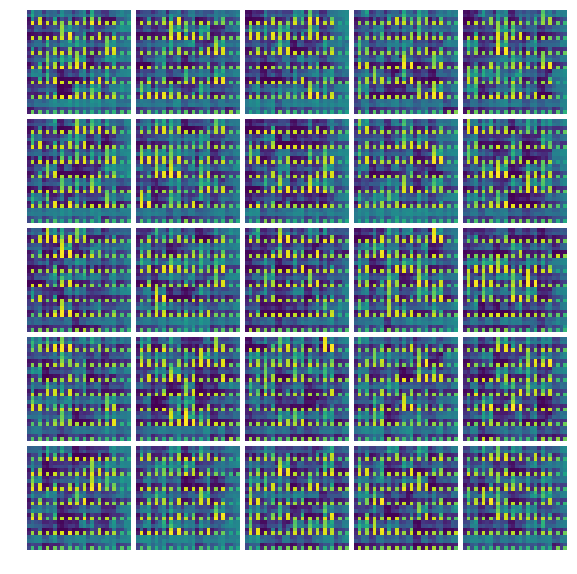

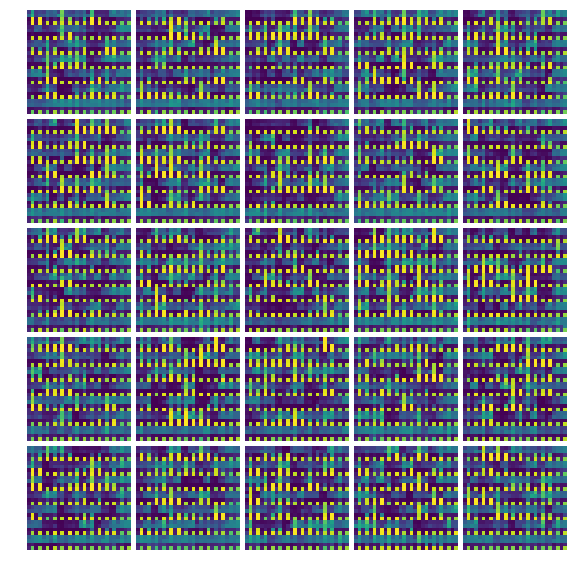

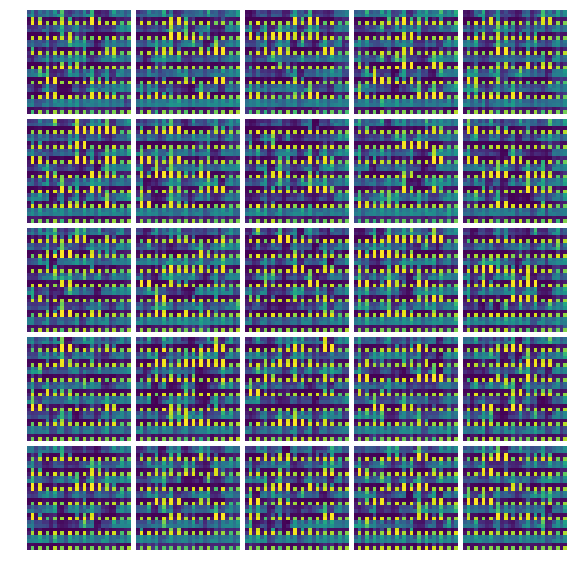

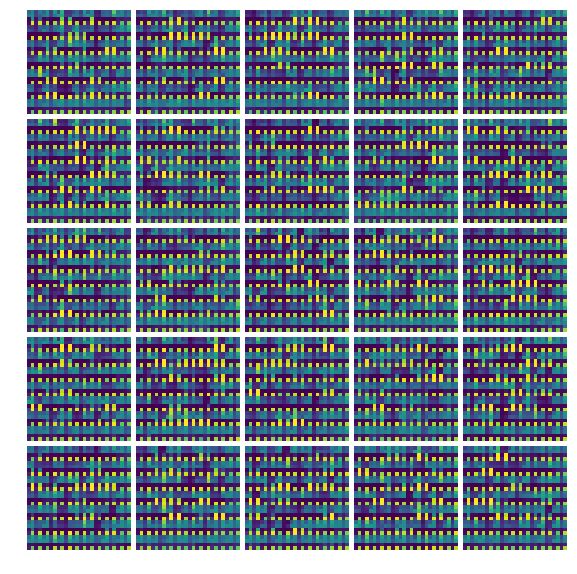

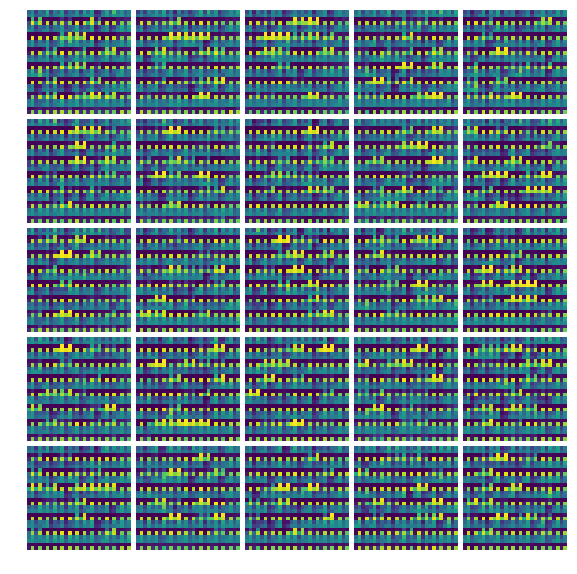

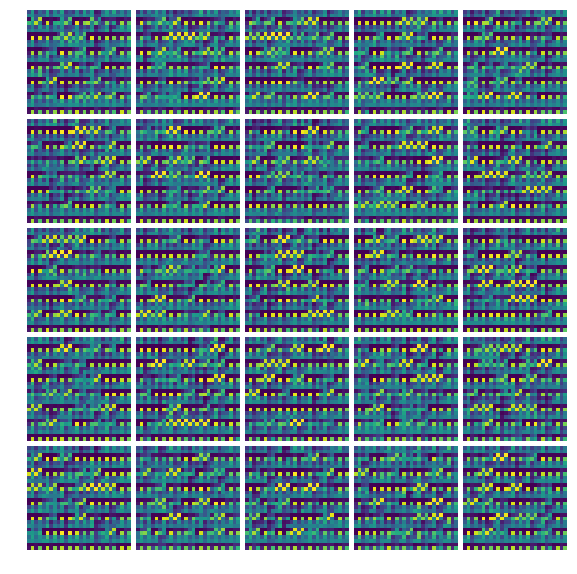

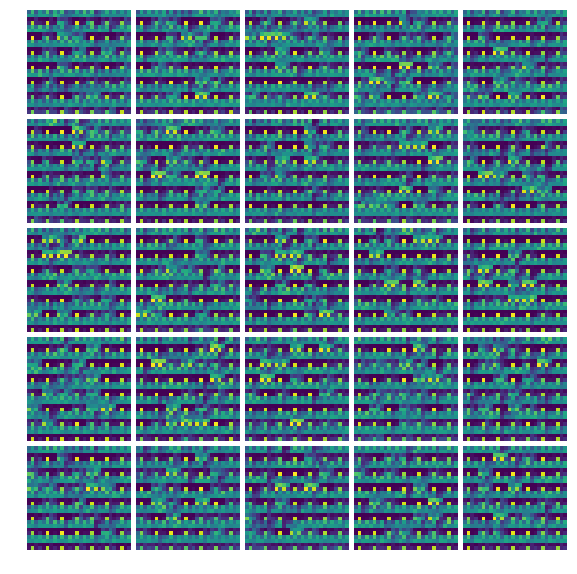

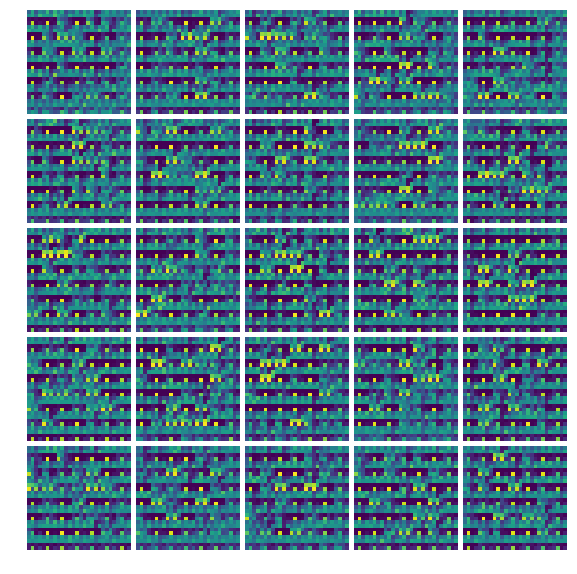

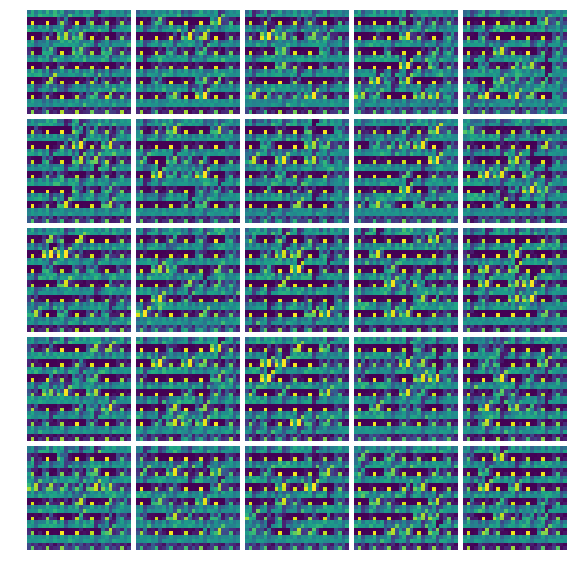

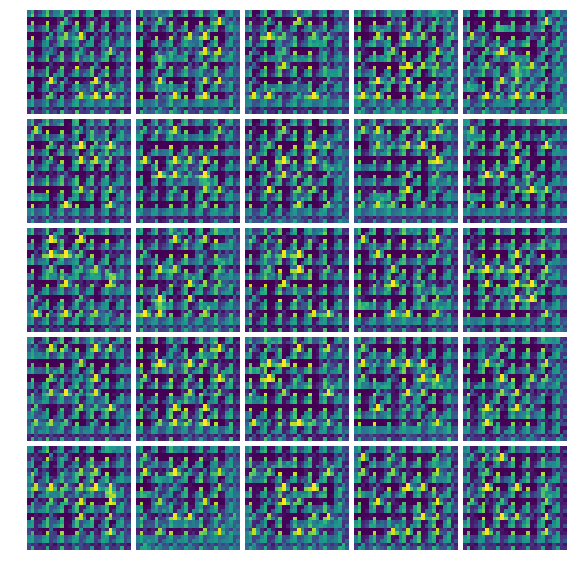

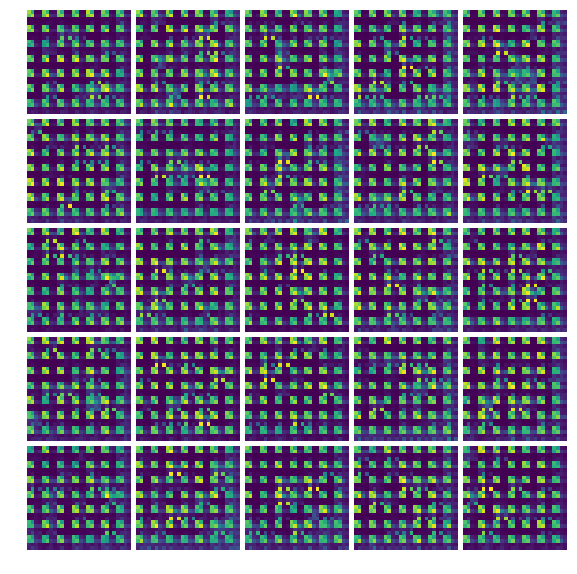

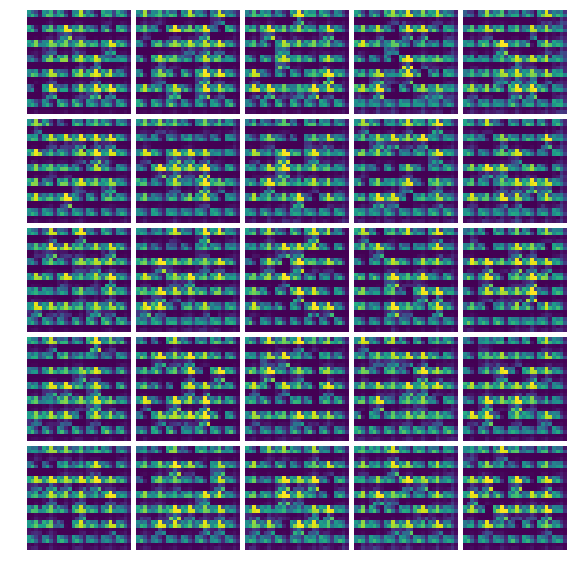

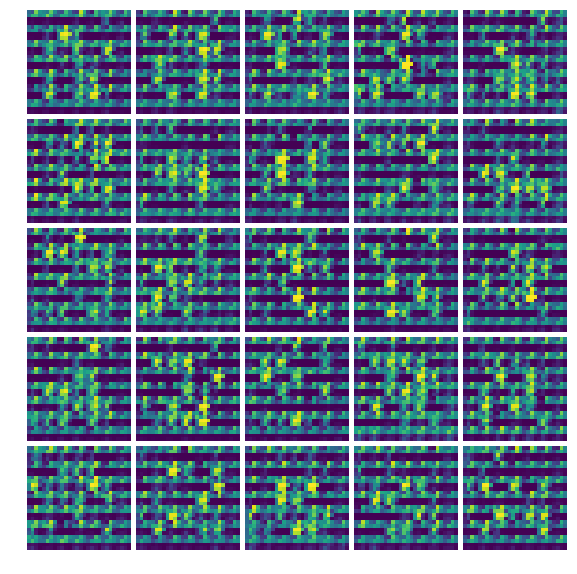

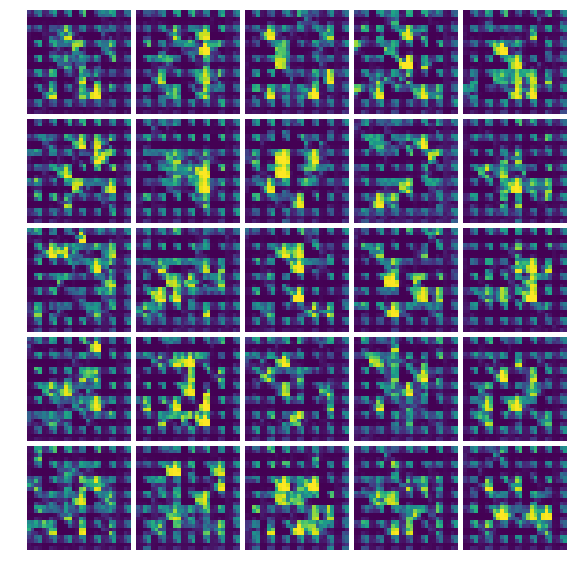

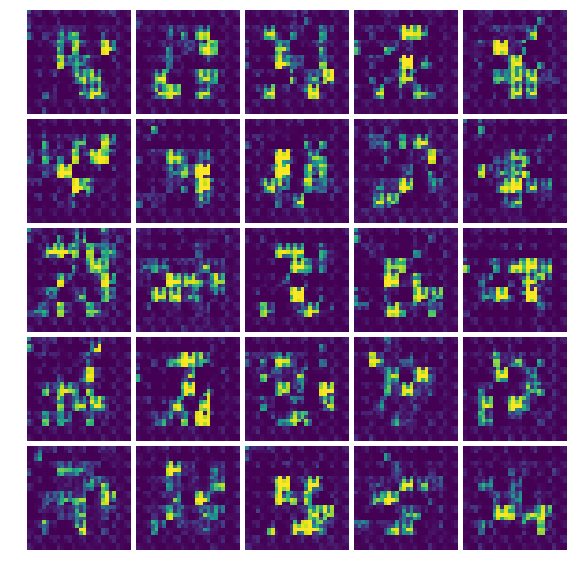

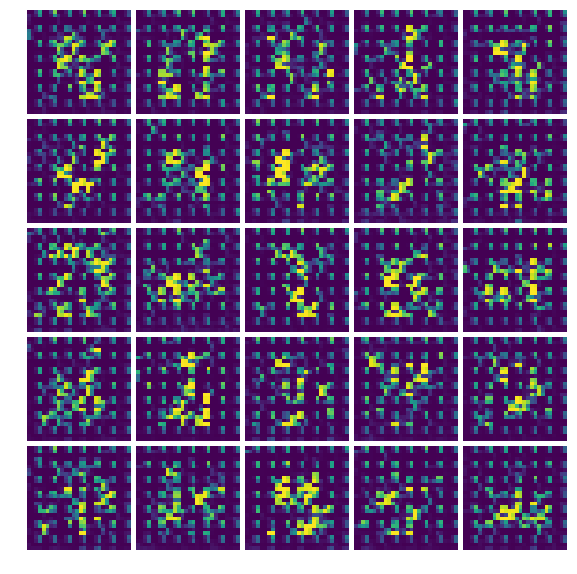

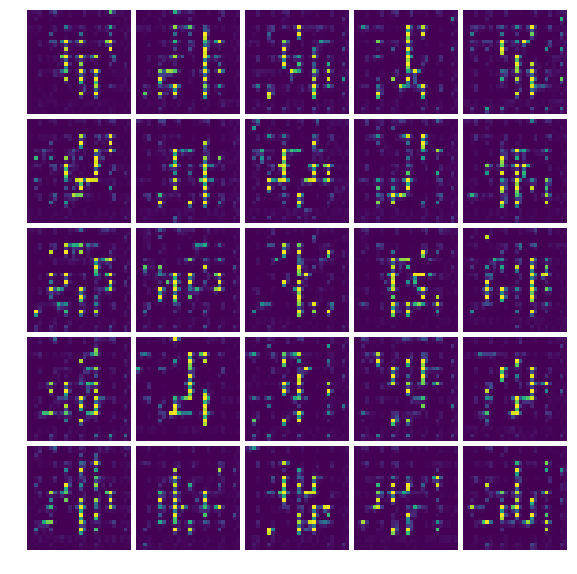

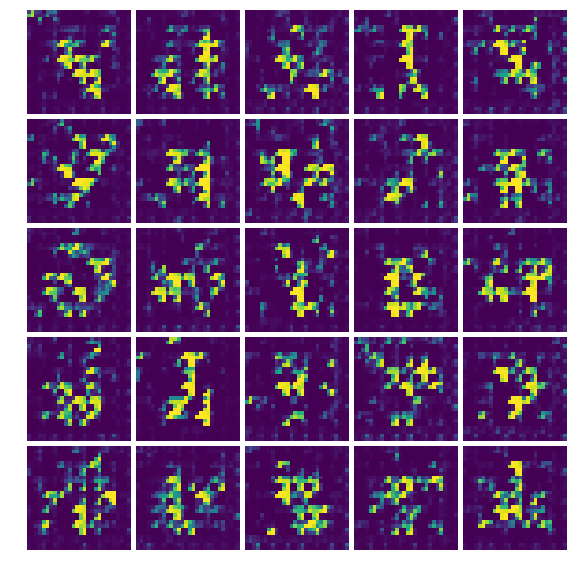

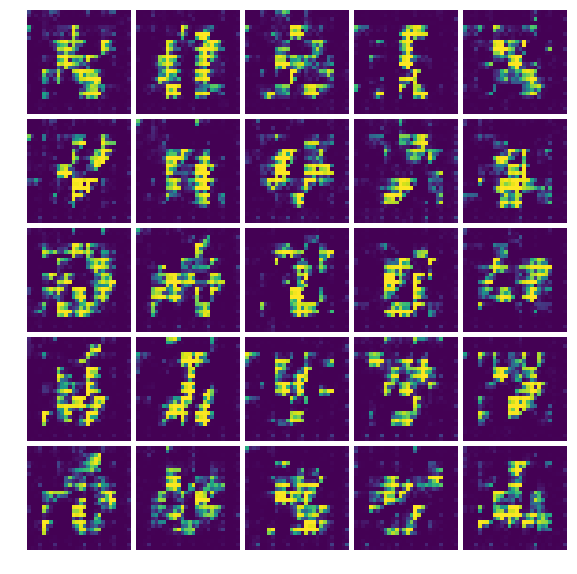

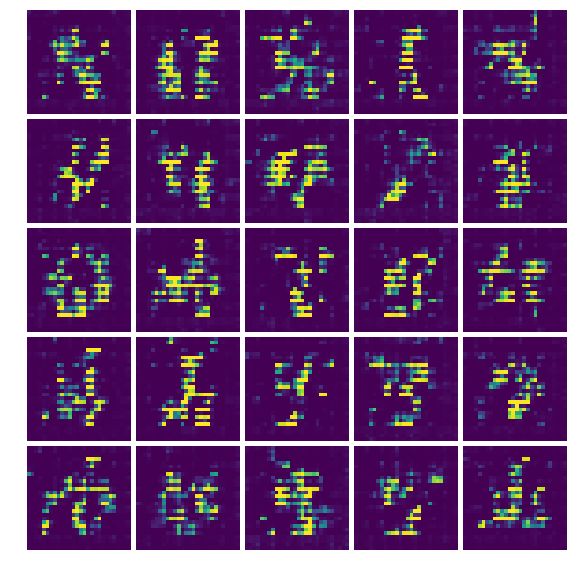

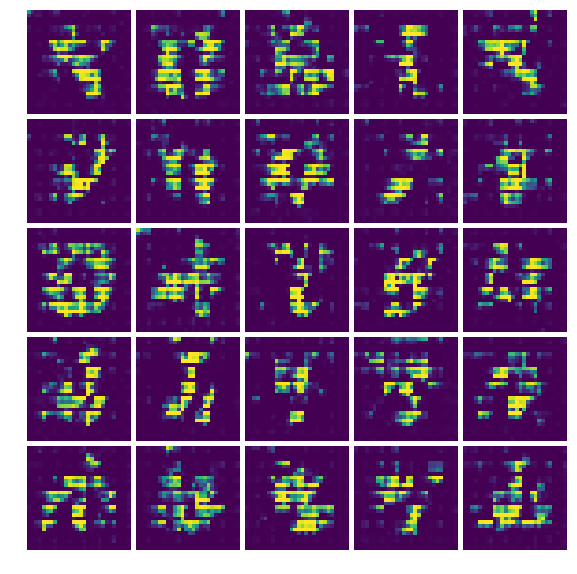

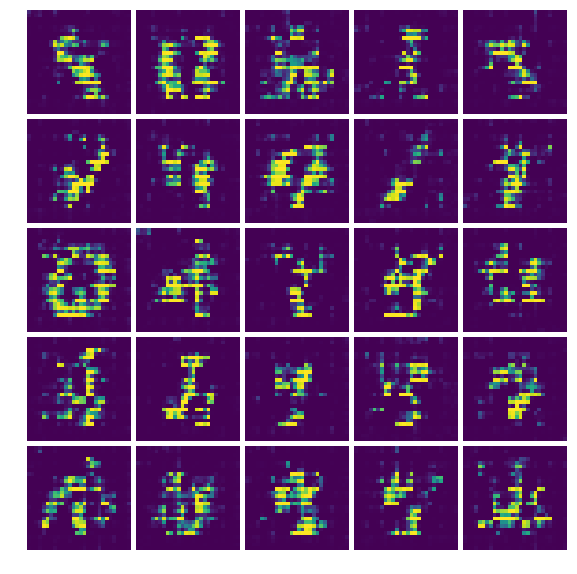

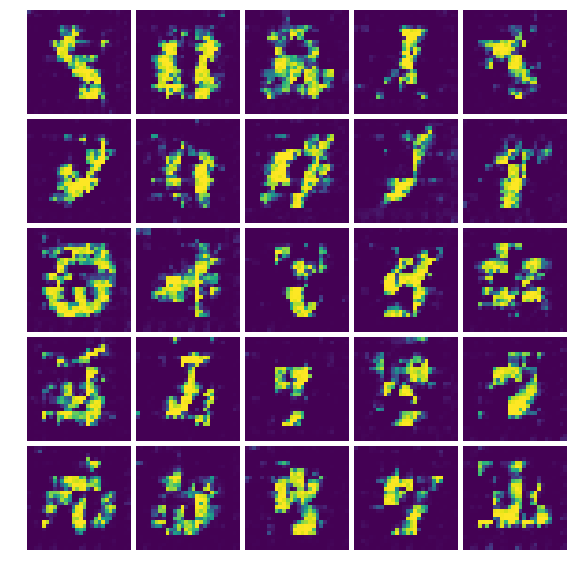

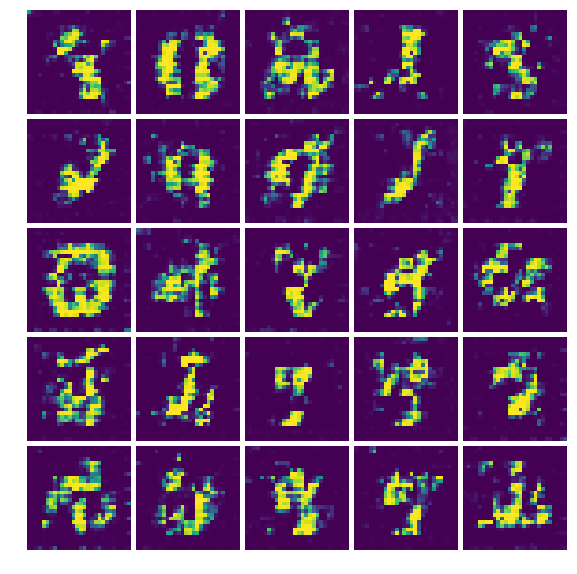

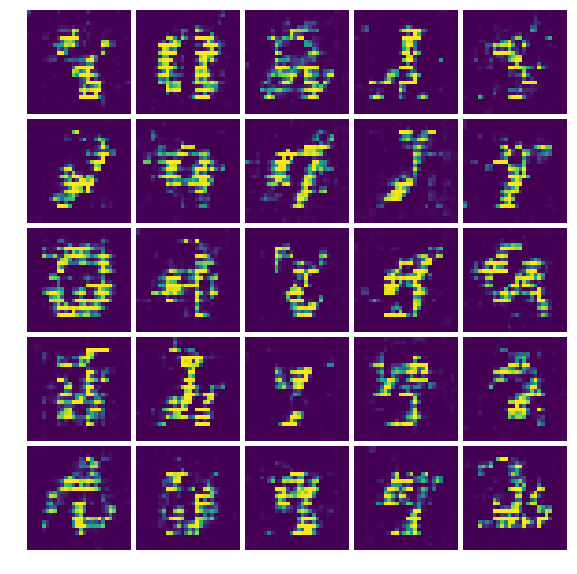

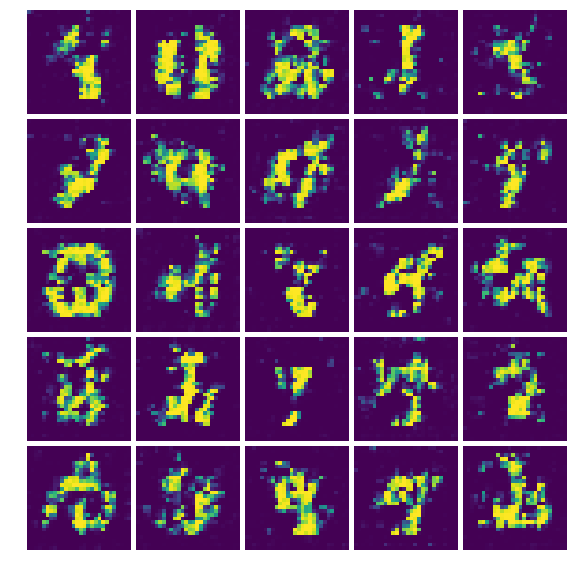

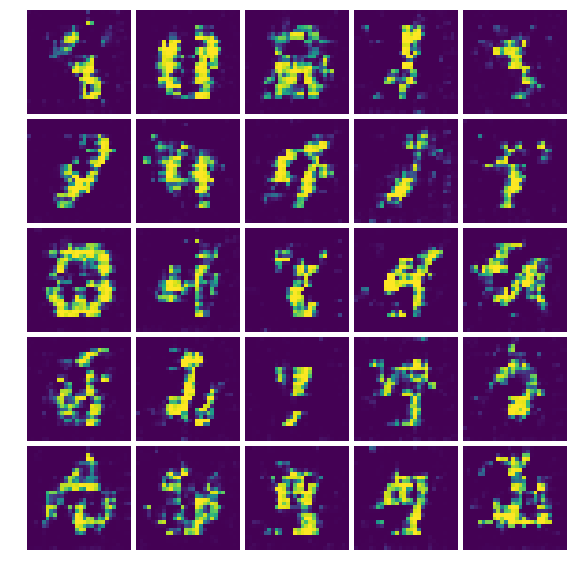

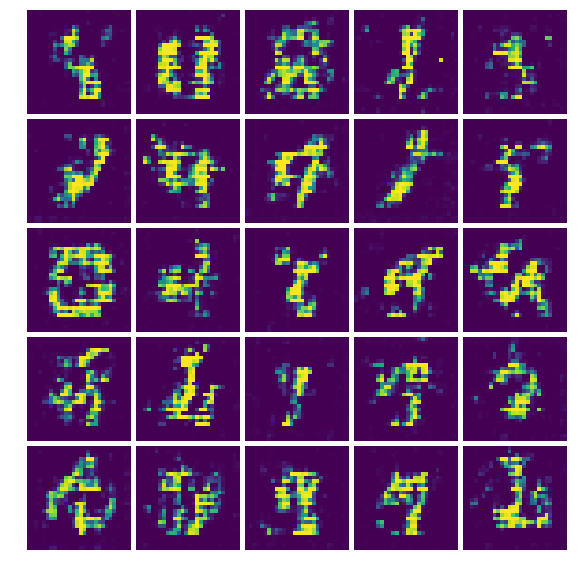

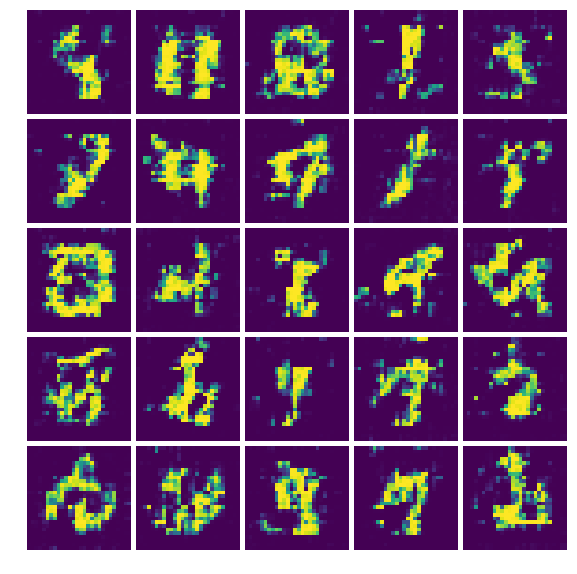

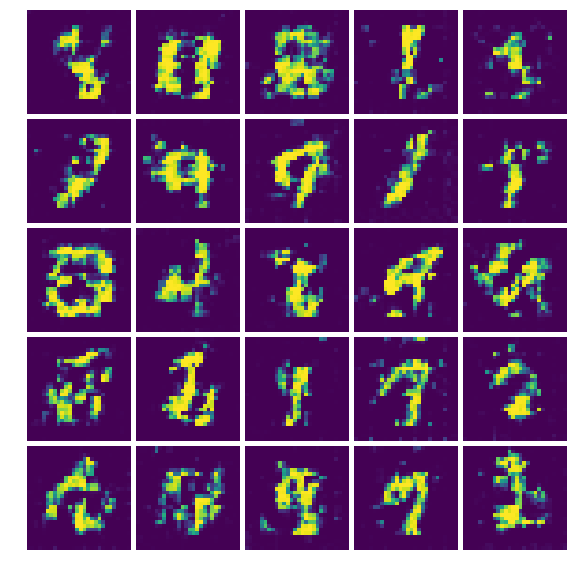

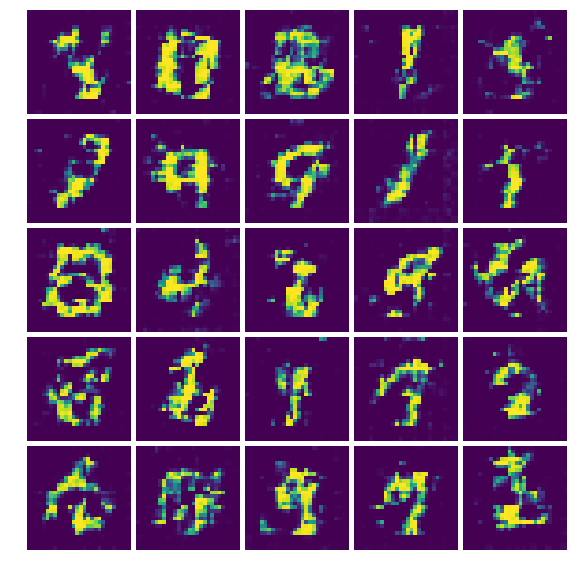

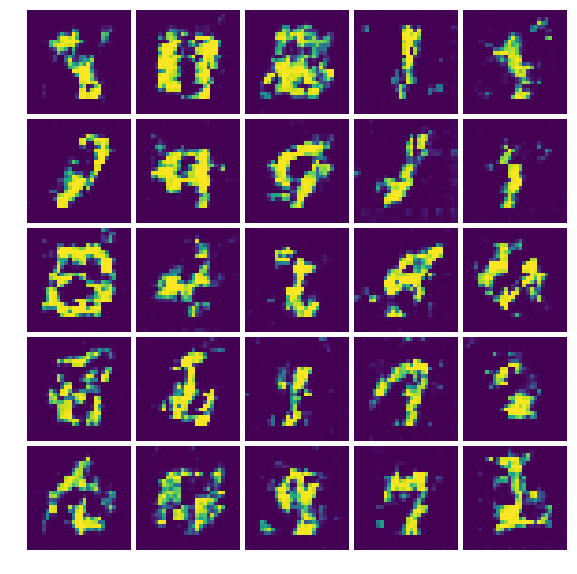

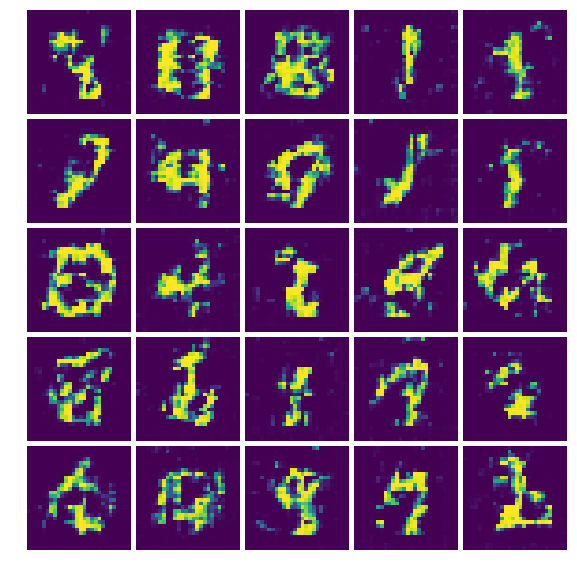

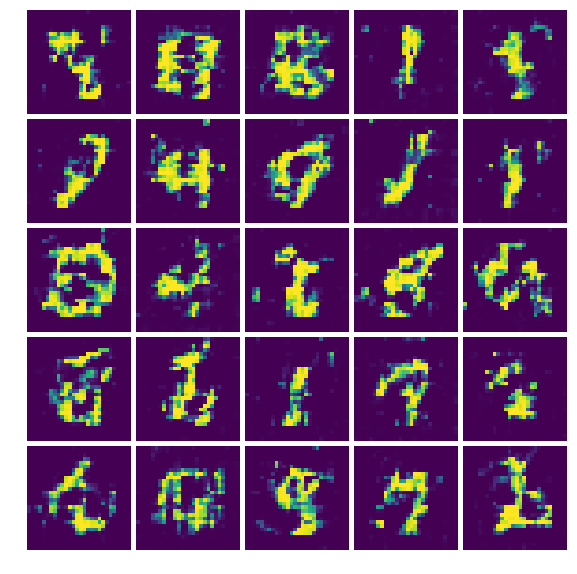

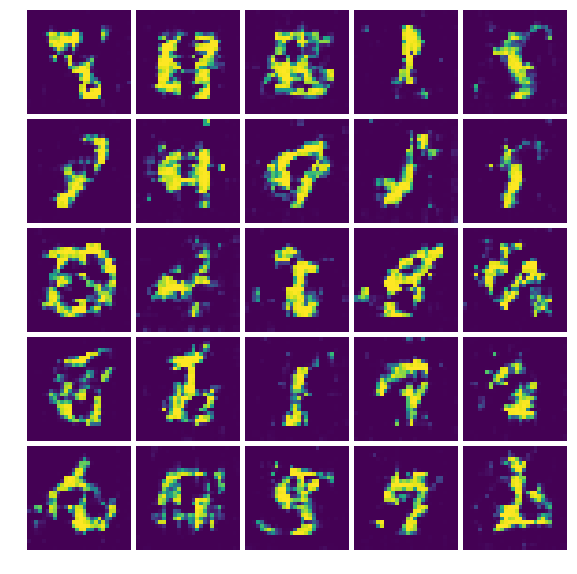

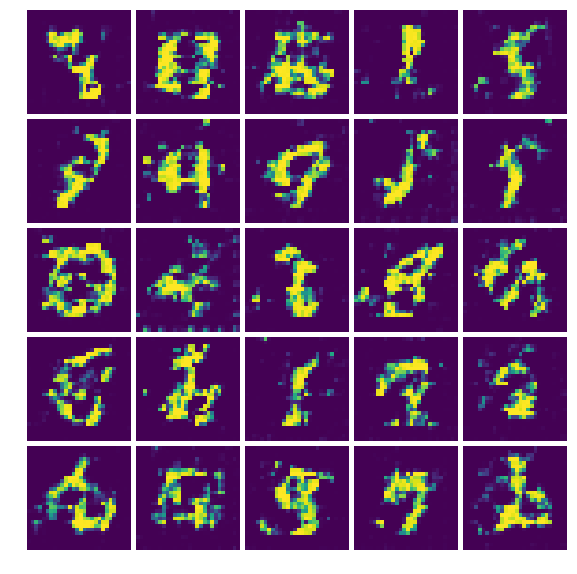

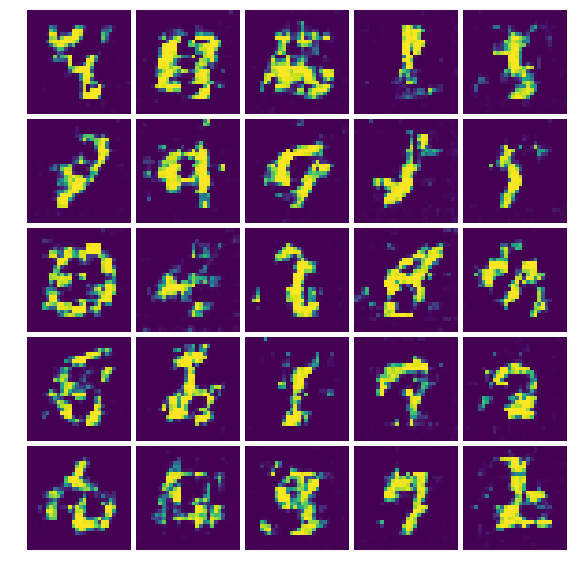

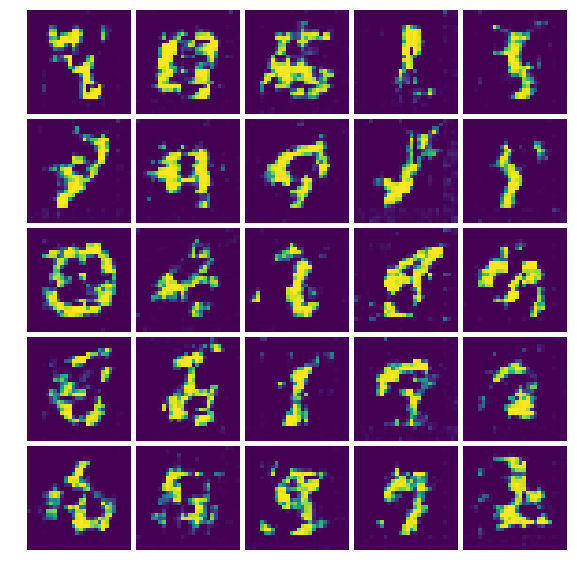

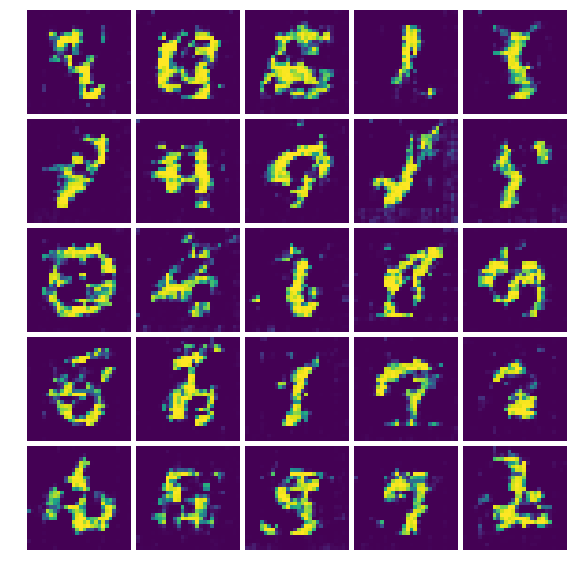

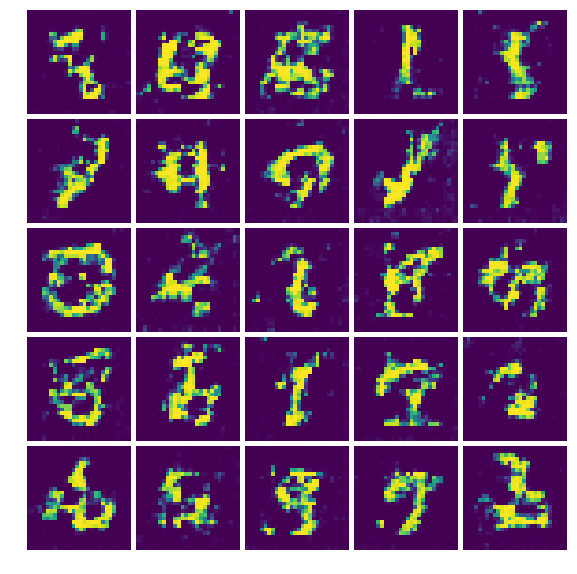

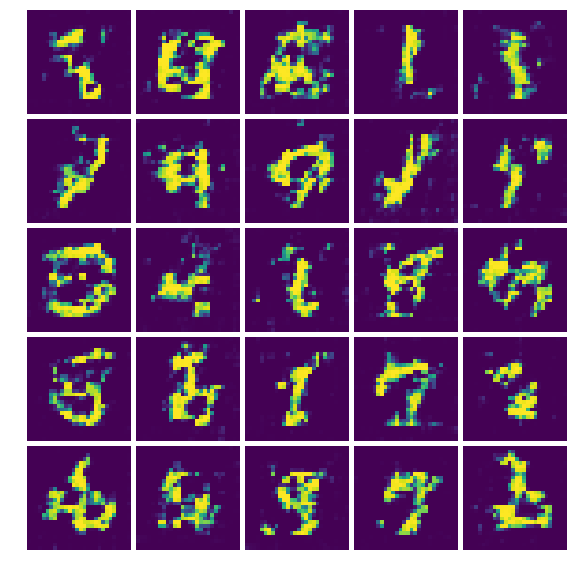

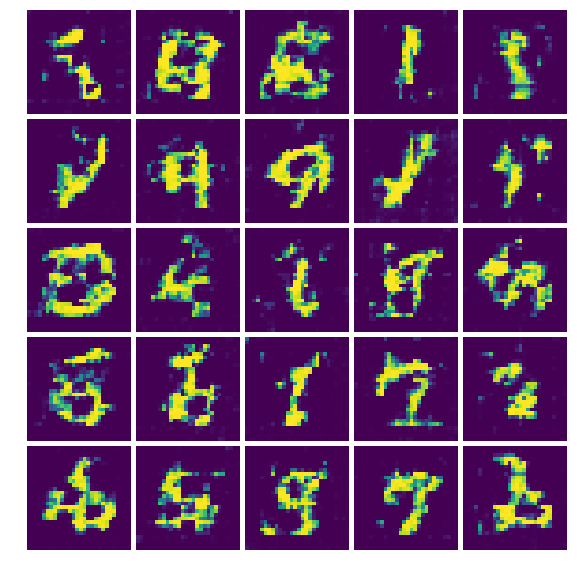

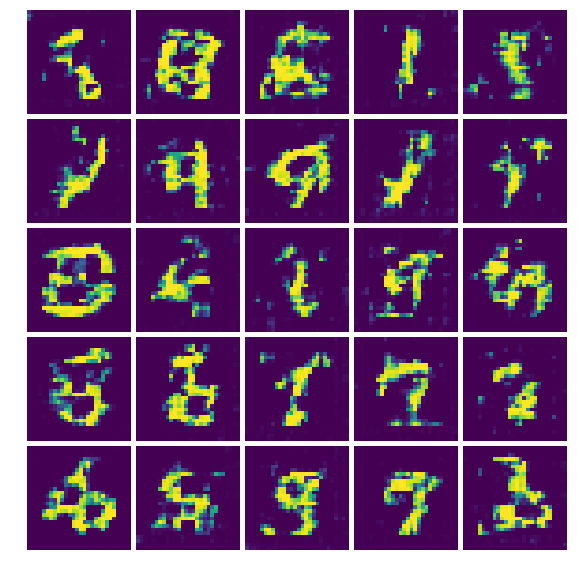

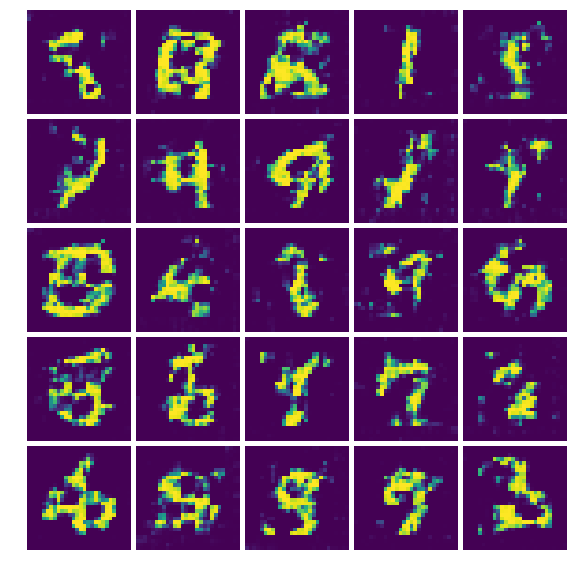

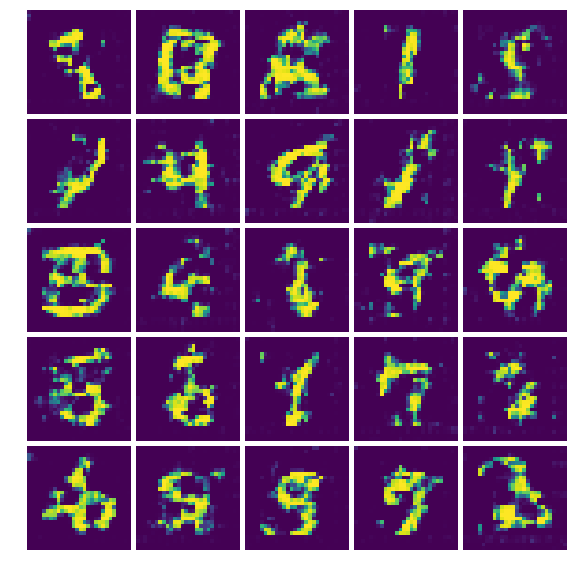

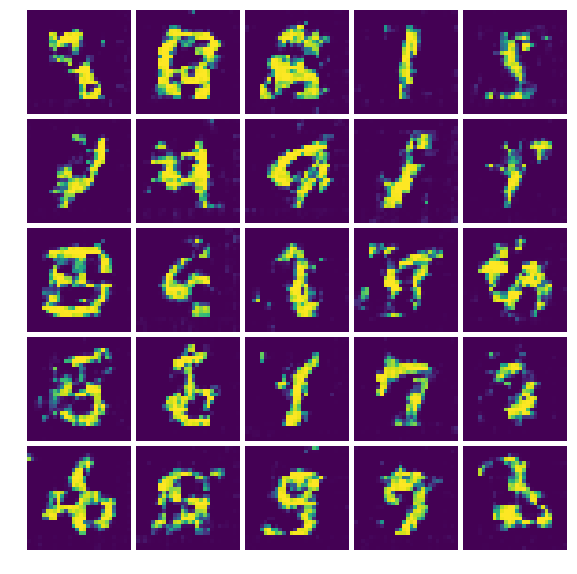

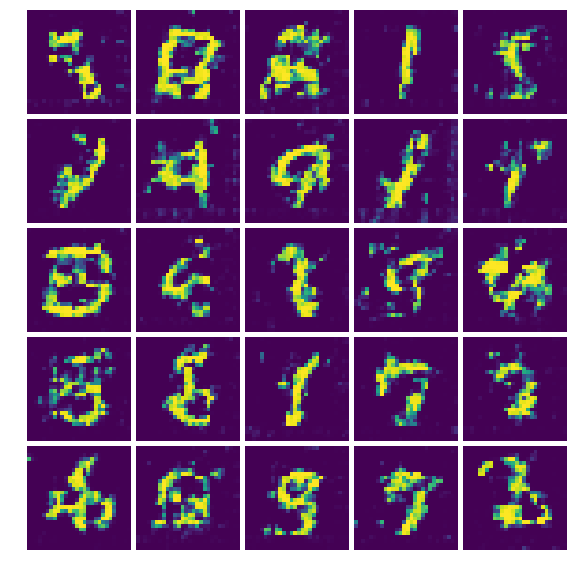

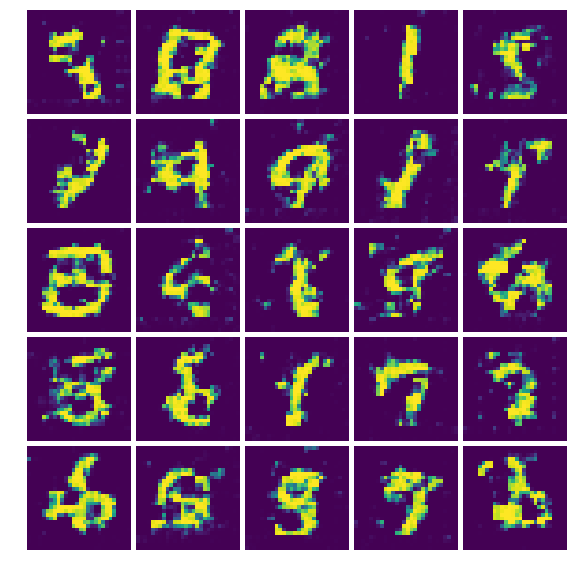

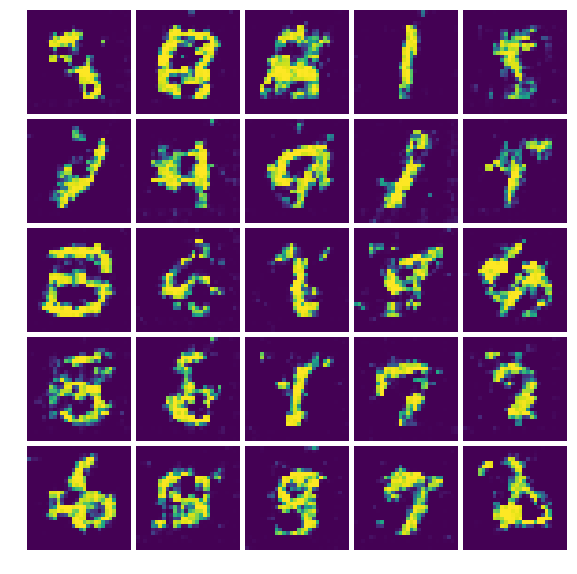

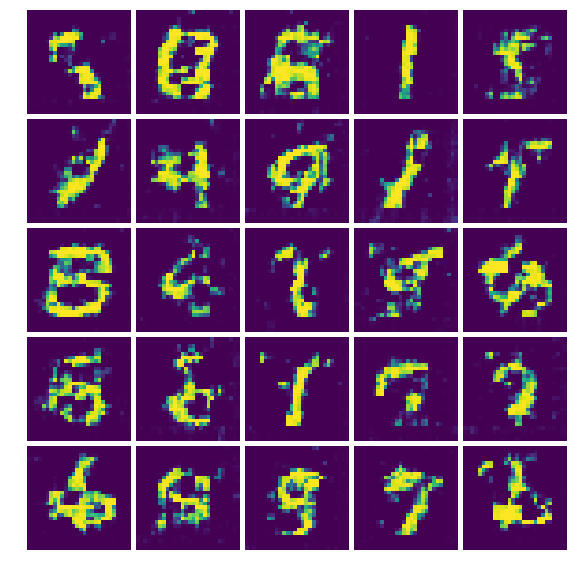

In [62]:
DCGAN()

In [11]:
#noise = np.random.normal(loc=0 , scale=0.2 , size=(3, 2, 1, 1))
#print(noise)

[[[[ 0.13897881]]

  [[ 0.11966697]]]


 [[[-0.47545968]]

  [[ 0.2212227 ]]]


 [[[ 0.19881932]]

  [[-0.03660763]]]]


In [9]:
test_noise = np.random.uniform(low=-1.0, high=1.0, size=(128, 1, 1, 100)) 
new_model = tf.keras.models.load_model('./checkpoints/FINAL-generator-2018-12-18 08:21:27.748321+01:00.h5')
new_model.summary()

TypeError: '<' not supported between instances of 'dict' and 'float'

In [22]:
#########################
# This cell shows that we don't need to reshape our initial noise
# We can just specify all dims when creating the noise
#########################
noise = np.random.uniform(low=-1.0, high=1.0, size=(2, 3))
print(noise.shape)
y = np.expand_dims(noise, axis=2)
print(y.shape)
z = np.expand_dims(y, axis=3)
print(z.shape)
print(z)
print()
print(np.random.uniform(low=-1.0, high=1.0, size=(2, 3,1,1)))

(2, 3)
(2, 3, 1)
(2, 3, 1, 1)
[[[[-0.15162636]]

  [[-0.31837529]]

  [[-0.26284121]]]


 [[[-0.37285482]]

  [[-0.00284007]]

  [[ 0.22228344]]]]

[[[[-0.29609413]]

  [[-0.24723667]]

  [[ 0.30993767]]]


 [[[-0.98739054]]

  [[-0.47790569]]

  [[-0.94762318]]]]


In [12]:
# Try different values and see the output dimensions of each layer
# Experiment and find suitable values

##########################
# GENERATOR
##########################
reset_graph()

batch_size = 128

model = tf.keras.Sequential()
noise = np.random.uniform(low=-1.0, high=1.0, size=(batch_size, 1, 1, 100))

model.add(layers.Conv2DTranspose(input_shape=(1, 1, 100), filters=128, kernel_size=(7,7), strides=(1,1), padding="valid",
                                 kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
model.add(layers.BatchNormalization(scale=False, center=False))
model.add(layers.ReLU())

model.add(layers.Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2), padding="valid",
                                 kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
model.add(layers.BatchNormalization(scale=False, center=False))
model.add(layers.ReLU())

model.add(layers.Conv2DTranspose(filters=1, kernel_size=(2,2), strides=(2,2), padding="valid",
                                 kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                                 activation='tanh'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         627328    
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         256       
_________________________________________________________________
re_lu (ReLU)                 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         257       
Total para

In [26]:
# Try different values and see the output dimensions of each layer
# Experiment and find suitable values

##########################
# DISCRIMINATOR
##########################


model = tf.keras.Sequential()
        
# Input is batchx28x28x1
model.add(layers.Conv2D(input_shape=(28, 28, 1), filters=64,
                        kernel_size=(2,2), strides=(2,2), padding="valid",
                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
model.add(layers.LeakyReLU(alpha=0.2))

# Input is batchx14x14x???
model.add(layers.Conv2D(filters=128, kernel_size=(2,2), 
                        strides=(2,2), padding="valid",
                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
model.add(layers.BatchNormalization(scale=False, center=False))
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Conv2D(filters=256, kernel_size=(6,6), 
                        strides=(2,2), padding="valid",
                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
model.add(layers.BatchNormalization(scale=False, center=False))
model.add(layers.LeakyReLU(alpha=0.2))

# Input is batchx7x7x???
model.add(layers.Flatten()) # Output is batchx7*7*128
model.add(layers.Dense(units=256, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                       activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 14, 14, 64)        320       
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 7, 7, 128)         32896     
_________________________________________________________________
batch_normalization_18 (Batc (None, 7, 7, 128)         256       
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 1, 1, 256)         1179904   
_________________________________________________________________
batch_normalization_19 (Batc (None, 1, 1, 256)         512       
__________

In [29]:
print(np.random.uniform(low=0, high=0.3, size=(100)).shape)

(100,)


In [32]:
print(train_imgs.shape)

(60000, 28, 28)


In [36]:
batch = 3
batch_size = 128
imgs = train_imgs[batch*batch_size:batch*batch_size+batch_size, :, :] # Extract a batch of training images
print(imgs.shape)

(128, 28, 28)


NameError: name '_buildGenerator' is not defined

In [45]:
def _buildGenerator():
#model = tf.keras.Input() # Sequential or Functional API?
    # In the blog post they use a reshape, is that neccessary? Investigate
    #noise = np.random.uniform(low=-1.0, high=1.0, size=(self.batch_size, 1, 1, 100))
    model = tf.keras.Sequential()

    # Read the link below to understand output shapes of Conv2DTranspose
    # https://stackoverflow.com/questions/50683039/conv2d-transpose-output-shape-using-formula
    # Output shape: (batch, new_rows, new_cols, filters)
    model.add(layers.Conv2DTranspose(input_shape=(1, 1, 100), filters=128, kernel_size=(7,7), 
                                     strides=(1,1), padding="valid",
                                     kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(layers.BatchNormalization(scale=False, center=False))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2), padding="valid",
                                     kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(layers.BatchNormalization(scale=False, center=False))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(filters=1, kernel_size=(2,2), strides=(2,2), padding="valid",
                                     kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                                     activation='tanh'))

    #model.summary()

    # Inspired by https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py
    #noise = tf.keras.Input(shape=(1, 1, 100))
    #image = model(noise)

    #return Model(noise, image)
    return model

def _buildDiscriminator():
    """
    Constructs the discriminator part of the DCGAN
    """
    ##########
    # Layers #
    ##########

    model = tf.keras.Sequential()

    # Input is batchx28x28x1
    model.add(layers.Conv2D(input_shape=(28, 28, 1), filters=64,
                            kernel_size=(2,2), strides=(2,2), padding="valid",
                            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Input is batchx14x14x???
    model.add(layers.Conv2D(filters=128, kernel_size=(2,2), 
                            strides=(2,2), padding="valid",
                            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(layers.BatchNormalization(scale=False, center=False))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(filters=256, kernel_size=(6,6), 
                            strides=(2,2), padding="valid",
                            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(layers.BatchNormalization(scale=False, center=False))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Input is batchx7x7x???
    model.add(layers.Flatten()) # Output is batchx7*7*128
    model.add(layers.Dense(units=1, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                           activation=tf.nn.sigmoid))

    #model.summary()
    return model
    
def build():
    model = tf.keras.Sequential()
    g = _buildGenerator()
    d = _buildDiscriminator()
    d.trainable = False
    model.add(g)
    model.add(d)
    model.summary()
    
build()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_28 (Sequential)   (None, 28, 28, 1)         660801    
_________________________________________________________________
sequential_29 (Sequential)   (None, 1)                 1214145   
Total params: 1,874,946
Trainable params: 660,417
Non-trainable params: 1,214,529
_________________________________________________________________
